In [1]:
import os
import sys
import pickle
import string
import string
import glob
import cv2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.cluster import AgglomerativeClustering
from matplotlib.animation import FuncAnimation, MovieWriter
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from itertools import product
from matplotlib import ticker

sys.path.append('..')
import massPy as mp
from utils import *
from plot_utils import *
from AnalyseDefects import AnalyseDefects
plt.style.use('sg_article')
plt.rcParams.update({"text.usetex": True,})

home_dir = os.environ['HOME']
projects_dir = os.environ['Projects']
working_dir = os.path.join(projects_dir, 'Thesis', 'NematicAnalysis',)
data_dir = os.path.join(working_dir, 'data', 'passive')
research_dir = os.environ['Research']


In [2]:

def extract_clp_results_single_v2(clustering_dict, act_dir_list, save_path = None):
    """
    Analyse the defects for all the input folders
    """

    Nframes = clustering_dict['Nframes']
  
    # create arrays to store the clustering data
    cluster_arr = np.nan * np.zeros([Nframes, clustering_dict['Nwindows'], 3, clustering_dict['Nact'],])
    nn_arr = np.nan * np.zeros([Nframes, 2, clustering_dict['Nact']])

    for i, act_dir in enumerate(act_dir_list):
        print(i, act_dir)
        try:
            cl_res = np.load(os.path.join(act_dir, 'cl_arr.npy'))
            ff_idx = min(Nframes, cl_res.shape[0])
            cluster_arr[-ff_idx:, :cl_res.shape[1], :, i] = cl_res[-ff_idx:]
        except:
            print(f"Error loading clustering data from {act_dir}")
        try:
            nn_res = np.load(os.path.join(act_dir, 'nn_arr.npy'))
            ff_idx = min(Nframes, nn_res.shape[0])
            nn_arr[-ff_idx:, :, i] = nn_res[-ff_idx:]
        except:
            print(f"Error loading nn data from {act_dir}")
            continue
            
    if save_path is not None:
        os.makedirs(save_path, exist_ok=True)
        np.save(os.path.join(save_path, f'clp_arr.npy'), cluster_arr)
        np.save(os.path.join(save_path, f'nn_arr.npy'), nn_arr)
    return cluster_arr

def extract_clp_results_single(clustering_dict, act_dir_list, save_path = None):
    """
    Analyse the defects for all the input folders
    """

    Nframes = clustering_dict['Nframes']
  
    # create arrays to store the clustering data
    cluster_arr = np.nan * np.zeros([Nframes, clustering_dict['Nwindows'], 3, clustering_dict['Nact'],])
    nn_arr = np.nan * np.zeros([Nframes, 2, clustering_dict['Nact']])

    for i, act_dir in enumerate(act_dir_list):
        print(i, act_dir)
        cl_res = np.load(os.path.join(act_dir, 'cl_arr.npy'))
        nn_res = np.load(os.path.join(act_dir, 'nn_arr.npy'))
        ff_idx = min(Nframes, cl_res.shape[0])
        cluster_arr[-ff_idx:, :cl_res.shape[1], :, i] = cl_res[-ff_idx:]
        nn_arr[-ff_idx:, :, i] = nn_res[-ff_idx:]

    if save_path is not None:
        if not os.path.isdir(save_path):
            os.makedirs(save_path)
        np.save(os.path.join(save_path, f'clp_arr.npy'), cluster_arr)
        np.save(os.path.join(save_path, f'nn_arr.npy'), nn_arr)
    return cluster_arr

def extract_op_results(Nframes, act_dir_list, LX, calc_sem = False, save_path = None):
    """
    Analyse the defects for all the input folders
    """

    order_param_arr = np.nan * np.zeros([Nframes, 4, len(act_dir_list)])
    normalizer = np.sqrt(LX ** 2) if calc_sem else 1

    for i, act_dir in enumerate(act_dir_list):
        print(i, act_dir)

        op_res = np.load(os.path.join(act_dir, 'order_param_arr.npy'))
        ff_idx = min(Nframes, op_res.shape[0])

        order_param_arr[-ff_idx:, :, i] = op_res[-ff_idx:]
        order_param_arr[-ff_idx:, 1, i] /= normalizer
        order_param_arr[-ff_idx:, 3, i] /= normalizer

    if save_path is not None:
        if not os.path.isdir(save_path):
            os.makedirs(save_path)
        np.save(os.path.join(save_path, f'order_param_arr.npy'), order_param_arr)
    return order_param_arr

def extract_dc_results(Nframes, act_dir_list, save_path = None):
    """
    Analyse the defects for all the input folders
    """

    for i, act_dir in enumerate(act_dir_list):
        print(i, act_dir)

        if i == 0:
            rvals = np.load(os.path.join(act_dir, 'rdf_rad_arr.npy'))
            rdf_arr = np.nan * np.zeros([Nframes, len(rvals), len(act_dir_list)])

        rdf = np.load(os.path.join(act_dir, 'rdf_arr.npy'))
        ff_idx = min(Nframes, rdf.shape[0])

        rdf_arr[-ff_idx:, :, i] = rdf[-ff_idx:]

    if save_path is not None:
        if not os.path.isdir(save_path):
            os.makedirs(save_path)
        np.save(os.path.join(save_path, f'rvals.npy'), rvals)
        np.save(os.path.join(save_path, f'rdf_arr.npy'), rdf_arr)
    return rdf_arr, rvals

def get_defect_arr_from_frame(defect_dict, return_charge = False):
    """
    Convert dictionary of defects to array of defect positions
    Parameters:
    -----------
    defect_dict : dict
        Dictionary of defects positions and charges
    return_charge : bool
        If True, return defect charges as well

    Returns:
    --------
    defect_positions : np.ndarray
        Array of defect positions
    defect_charges : np.ndarray
    """

    Ndefects = len(defect_dict)
    if Ndefects == 0:
        return None
    
    defect_positions = np.empty([Ndefects, 3 if return_charge else 2])

    for i, defect in enumerate(defect_dict):
        if return_charge:
            defect_positions[i,:] = *defect['pos'], defect['charge']
        else:
            defect_positions[i,:] = *defect['pos'],
    return defect_positions

def arg_func(arr, r_max_list, cutoff):
    if np.any(arr == cutoff):
        return r_max_list[np.argwhere(arr == cutoff)[0][0]]
    else:
        return -1
    
def arg_func_idx(arr, cutoff):
    if np.any(arr == cutoff):
        return np.argwhere(arr == cutoff)[0][0]
    else:
        return -1

def arg_func2(arr, cutoff):
    if np.any(arr == cutoff):
        return arr[np.argwhere(arr == cutoff)[0][0]]
    else:
        return -1
    
def get_defect_density(defect_list, area, return_charges=False, save_path = None,):
        """
        Get defect density for each frame in archive
        parameters:
            defect_list: list of lists of dictionaries holding defect charge and position for each frame 
            area: Area of system
            return_charges: if True, return list of densities of positive and negative defects
        returns:
            dens_defects: array of defect densities (Nframes, 3) if return_charges is True else (Nframes, 2)
        """

        if return_charges:
            # Initialize list of defect densities
            dens_pos_defects = []
            dens_neg_defects = []
            for defects in defect_list:
                # Get no. of defects
                nposdef = len([d for d in defects if d['charge'] == 0.5])
                nnegdef = len([d for d in defects if d['charge'] == -0.5])

                dens_pos_defects.append(nposdef / area)
                dens_neg_defects.append(nnegdef / area)

            if save_path is not None:
                np.savetxt(save_path + '_pos', dens_pos_defects)
                np.savetxt(save_path + '_neg', dens_neg_defects)
            return dens_pos_defects, dens_neg_defects
        else:
            dens_defects = []
            for defects in defect_list:
                # Get no. of defects
                ndef = len(defects)
                dens_defects.append(ndef / area)
            if save_path is not None:
                np.savetxt(save_path, dens_defects)
            return dens_defects

def find_conv_time(def_arr, act_list, out_path, fig_path, ninfo, LX, mode='fwd', plot_density = False, \
                   stationarity_dict = dict(interval_len = 20, Njump = 20, Nconverged = -100, max_sigma_dist = 1)):

    Nframes, Nact = def_arr.shape
    conv_list = np.zeros(Nact)

    ncols=3
    nrows = np.ceil(Nact / ncols).astype(int)
    fig, ax = plt.subplots(nrows=nrows,ncols=ncols, figsize=(12, 3*nrows))
    ax = ax.flatten()


    for i, act in enumerate(act_list):

            normalizer = LX ** 2 if plot_density else 1
            vals = def_arr[:, i] / normalizer

            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                x = est_stationarity(vals, **stationarity_dict)[0]

            conv_list[i] = x
            ax[i].plot(np.arange(0, Nframes * ninfo, ninfo), vals, '.',
                        alpha = .5, markersize=9, label = rf'$dQ$ = {act}')
        
            if x > 0:
                ax[i].axvline(x * ninfo, color='black', linestyle='--', alpha=0.5)
            ylims = ax[i].get_ylim()

            ax[i].set_ylim([ylims[0], 1.1 * ylims[1]])
            ax[i].legend()  
            ax[i].grid(True)


    fig.supxlabel('Time')
    fig.supylabel('Number of defects')


    np.save(os.path.join(out_path, 'conv_list.npy'), conv_list)
    fig.savefig(os.path.join(fig_path, f'num_defects_{mode}{LX}.png'))

    # close figure
    plt.close(fig)
    return

def calc_lmax_lperc(clp_arr, rmax_list, act_list, conv_list, save_path, uncertainty_multiplier = 1, nmin_frames = 20):
    

    lmax_av = np.nan * np.zeros((len(act_list), 2))
    lperc_av = np.nan * np.zeros((len(act_list), 2))

    arg_func1d = lambda arr: arg_func(arr, rmax_list, cutoff = 1)
    lmax_arr = np.apply_along_axis(arg_func1d, axis=1, arr=clp_arr[:, :, -1, :,])
    lperc_arr = np.apply_along_axis(arg_func1d, axis=1, arr=clp_arr[:, :, 0, :,])

    for i, _ in enumerate(act_list):
        ff_idx = int(conv_list[i])

        mask = (lmax_arr[ff_idx:, i,] > 0)
        nsamples = mask.sum()
        if nsamples > nmin_frames:
            arr_res = lmax_arr[ff_idx:, i,][mask]
            lmax_av[i,0] = np.nanmean(arr_res)
            lmax_av[i,1] = np.nanstd(arr_res, ddof = 1,) / np.sqrt(nsamples / uncertainty_multiplier)


        mask_perc = (lperc_arr[ff_idx:, i,] > 0)
        nsamples_perc = mask_perc.sum()
        if nsamples_perc  > nmin_frames:
            arr_res_perc = lperc_arr[ff_idx:, i,][mask_perc]
            lperc_av[i,0] = np.nanmean(arr_res_perc)
            lperc_av[i,1] = np.nanstd(arr_res_perc, ddof = 1,) / np.sqrt(nsamples_perc / uncertainty_multiplier)

    np.save(os.path.join(save_path, 'lmax_arr.npy'), lmax_arr)
    np.save(os.path.join(save_path, 'lperc_arr.npy'), lperc_arr)
    np.save(os.path.join(save_path, 'lmax_av.npy'), lmax_av)
    np.save(os.path.join(save_path, 'lperc_av.npy'), lperc_av)
    return

def calc_nn_avg(nn_arr, def_arr, act_list, conv_list, LX, \
                uncertainty_multiplier = 1, weighted=False, \
                normalize = True, nmin_samples = 20, 
                save_path = None):
    
    nn_av = np.nan * np.zeros((len(act_list), 2))

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        for j in range(len(act_list)):
            ff_idx = int(conv_list[j])
            normalizer = LX / np.sqrt(def_arr[ff_idx:,j]) if normalize else 1
            
            if (nn_arr[:,0,j] > 0).sum() >=  nmin_samples:
                if weighted:
                    nn_av[j] = calc_weighted_mean_vec(nn_arr[ff_idx:,0,j] / normalizer, 
                                                                nn_arr[ff_idx:,1,j] / normalizer, replace_null_uncertainties=True)[:2]
                    nn_av[j,1] *= np.sqrt(uncertainty_multiplier)
                else:
                    nn_av[j,0] = np.nanmean(nn_arr[ff_idx:,0,j] / normalizer)
                    nn_av[j,1] = (np.nanstd(nn_arr[ff_idx:,0,j] / normalizer, ddof = 1,) + np.nanmean(nn_arr[ff_idx:,1,j] / normalizer)) \
                                 / np.sqrt(nn_arr[ff_idx:,0,j].size / uncertainty_multiplier)           
    if save_path is not None:
        if not os.path.isdir(save_path):
            os.makedirs(save_path)
        np.save(os.path.join(save_path, 'nn_av.npy'), nn_av)
    return nn_av

def calc_dc_avg(rdf_arr, act_list, conv_list, \
                uncertainty_multiplier = 1, njump=5,
                save_path = None):
    

    
    rdf_arr_av = np.nan * np.zeros((len(act_list), 2, rdf_arr.shape[1]))
  
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        for j in range(len(act_list)):
            ff_idx = int(conv_list[j] / njump)
            rdf_arr_res = rdf_arr[ff_idx:,:,j]
            #nan_mask = np.isnan(rdf_arr_res)
            #rdf_arr_res = rdf_arr_res[~nan_mask]

            rdf_arr_av[j,0,:] = np.nanmean(rdf_arr_res, axis=0)
            rdf_arr_av[j,1,:] = np.nanstd(rdf_arr_res, axis=0, ddof = 1,) \
                / np.sqrt(rdf_arr_res.size / uncertainty_multiplier)        
    if save_path is not None:
        if not os.path.isdir(save_path):
            os.makedirs(save_path)
        np.save(os.path.join(save_path, 'rdf_arr_av.npy'), rdf_arr_av)
    return rdf_arr_av

def calc_order_param_avg(order_param_arr, act_list, conv_list, \
                uncertainty_multiplier = 1, weighted=False, \
                save_path = None):
    
    order_param_av = np.nan * np.zeros((len(act_list), 4))

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        for j in range(len(act_list)):
            ff_idx = int(conv_list[j])
   
            if weighted:
                order_param_av[j, :2] = calc_weighted_mean_vec(order_param_arr[ff_idx:,0,j], 
                                                            order_param_arr[ff_idx:,1,j] * np.sqrt(uncertainty_multiplier))[:2]
                order_param_av[j, 2:] = calc_weighted_mean_vec(order_param_arr[ff_idx:,2,j], 
                                                            order_param_arr[ff_idx:,3,j] * np.sqrt(uncertainty_multiplier))[:2]
                order_param_av[j,1] *= np.sqrt(uncertainty_multiplier)
                order_param_av[j,3] *= np.sqrt(uncertainty_multiplier)
            else:
                order_param_av[j,0] = np.nanmean(order_param_arr[ff_idx:,0,j])
                order_param_av[j,1] = np.nanstd(order_param_arr[ff_idx:,0,j], ddof = 1,) \
                    / np.sqrt(order_param_arr[ff_idx:,0,j].size / uncertainty_multiplier)           
                order_param_av[j,2] = np.nanmean(order_param_arr[ff_idx:,2,j])
                order_param_av[j,3] = np.nanstd(order_param_arr[ff_idx:,2,j], ddof = 1,) \
                    / np.sqrt(order_param_arr[ff_idx:,2,j].size / uncertainty_multiplier)           
    if save_path is not None:
        if not os.path.isdir(save_path):
            os.makedirs(save_path)
        np.save(os.path.join(save_path, 'order_param_av.npy'), order_param_av)
    return order_param_av
        
def plot_order_param(order_param_arr, act_list, Nframes, ninfo, \
                    act_idx_exclude_list = [], lambda_val=None, save_path=None, \
                    ylim = None, mode = 'wet', direction = 'fwd'):
    
    fig, ax = plt.subplots()

    direction = 'forward' if direction == 'fwd' else 'backward'

    for j in range(len(act_list)):
        if j in act_idx_exclude_list: continue

        xvals = np.arange(0, Nframes * ninfo, ninfo)
        ax.plot(xvals, order_param_arr[:,0,j], '.-', label  = f'{act_list[j]}', alpha = .5)
    ax.set_xlabel('Time step')
    ax.set_ylabel('Order parameter (S)')

    ax.legend(ncols=7, loc='upper right',fontsize=12)   
    ax.set_title(rf' $\lambda = ${lambda_val} ({direction})' if mode == 'wet' else rf'Dry ({direction})')
    if ylim is not None:
        ax.set_ylim(ylim)

    fig.tight_layout()  

    if save_path is not None:
        fig.savefig(save_path)
    return fig, ax

def plot_order_param_double(order_param_arr, act_list, idx_lower, Nframes, ninfo, \
                    act_idx_exclude_list = [], lambda_val=None, save_path=None, \
                    ylim_list = None, mode = 'wet', direction = 'fwd'):
    
    fig, ax = plt.subplots(ncols=2, figsize=(12, 6))
    for j in range(len(act_list)):
        if j in act_idx_exclude_list: continue
        ff_idx = 0
        ax[0 if j<idx_lower else 1].plot(order_param_arr[:,0,j], label  = f'{act_list[j]}')
    fig.supxlabel('Time step')
    fig.supylabel('Order parameter (S)')
    fig.suptitle(rf' $\lambda = ${lambda_val} ({direction})' if mode == 'wet' else rf'Dry ({direction})')
    fig.tight_layout()

    for i, axx in enumerate(ax):
        axx.set_ylim([-.05, .25]) if ylim_list is None else axx.set_ylim(ylim_list[i])
        axx.legend(ncol=4, loc='upper right', fontsize=12)

    if save_path is not None:
        fig.savefig(save_path)
    return fig, ax


In [26]:
LX = 256
mode = 'wetmerge' #merge' 
save_figs = False
letter_subfigs = True
calc_order_param_sem = False

extract = False
extract_op, extract_dc =False,False
extract_def, find_conv =False, False
analyze=False

nmin_frames = 10 #if #mode == 'wet' else 5
uncertainty_multiplier = 20
njump_between_frames = 5

rmax_list = np.arange(1, int(LX / np.sqrt(2))) 
Nframes = 1000 #if mode=='wet' #else 50
Nwindows = len(rmax_list)
ninfo = 1000

block_size = 20 #if mode=='wet' else 5
Nconverged = 5*block_size

weighted = False

if mode == 'wet':
    folder_name = 'diff_lambda_periodic'
    lambda_list = [0,1]#1]# 1] # [0.1, 0.5, 0.8]#1] #1]
    subdir_name = 'wet'
elif mode == 'dry':
    folder_name = 'dry_periodic_long'
    lambda_list = [1,]
    subdir_name = 'dry'
elif mode == 'dryvl':
    folder_name = 'dry_periodic_vl'
    lambda_list = [1,]
    subdir_name = 'dry'
elif mode == 'wetvl':
    folder_name = 'diff_lambda_periodic_vl'
    lambda_list = [0,1]
    subdir_name = 'wet'
elif mode == 'wetmerge':
    folder_name = 'diff_lambda_merge'
    lambda_list = [0,1,]#1]
    subdir_name = 'wet'
elif mode == 'ac':
    folder_name = 'ac_periodic'
    lambda_list = [0,1]
    subdir_name = 'wet'

base_path = f'Z:\\defect_unbinding\\{folder_name}\\{subdir_name}\\na{LX}'
out_path_all = os.path.join(working_dir, f'data\\passive\\{folder_name}\\{mode}\\na{LX}')
figpath_article=os.path.join(research_dir, f'DefectUnbinding\\Figs\\{folder_name}\\{mode}\\na{LX}') 

os.makedirs(out_path_all, exist_ok=True)
os.makedirs(figpath_article, exist_ok=True)

for lambda_val in lambda_list:

    if mode in ['dry', 'dryvl']:
        base_path_fwd = os.path.join(base_path, 'fwd')
        base_path_bck = os.path.join(base_path, 'bck')
    else:
        base_path_fwd = os.path.join(base_path, f'{lambda_val}', 'fwd')
        base_path_bck = os.path.join(base_path, f'{lambda_val}', 'bck')

    out_path_main = os.path.join(out_path_all, f'{lambda_val}')
    out_path_fwd = os.path.join(out_path_main, 'fwd')
    out_path_bck = os.path.join(out_path_main, 'bck')
    fig_path = os.path.join(out_path_main, 'figs')

    extract_fwd = True if (os.path.exists(base_path_fwd) or os.path.exists(out_path_fwd)) else False
    extract_bck = True if (os.path.exists(base_path_bck) or os.path.exists(out_path_bck)) else False

    if extract or extract_def or extract_op or extract_dc:
        if not os.path.isdir(fig_path): os.makedirs(fig_path)
        if not os.path.isdir(out_path_main): os.makedirs(out_path_main)
        if not os.path.isdir(out_path_fwd): os.makedirs(out_path_fwd)
        if not os.path.isdir(out_path_bck): os.makedirs(out_path_bck)

        print(f'Analyzing {mode} with lambda = {lambda_val}')
        t1 = time.perf_counter()    

        act_dirs_fwd = [os.path.join(base_path_fwd, x) for x in os.listdir(base_path_fwd)] if extract_fwd else []
        act_dirs_bck = [os.path.join(base_path_bck, x) for x in os.listdir(base_path_bck)] if extract_bck else []
        act_fwd = [float(x.split('-')[-2]) for x in os.listdir(base_path_fwd)] if extract_fwd else []
        act_bck = [float(x.split('-')[-2]) for x in os.listdir(base_path_bck)] if extract_bck else []

        # save activity list
        if extract_fwd:
            np.save(os.path.join(out_path_fwd, 'act_fwd.npy'), act_fwd)
        if extract_bck:
            np.save(os.path.join(out_path_bck, 'act_bck.npy'), act_bck)
    else:
        act_fwd = np.load(os.path.join(out_path_fwd, 'act_fwd.npy')) if extract_fwd else []
        act_bck = np.load(os.path.join(out_path_bck, 'act_bck.npy')) if extract_bck else []

    act_exclude_fwd = []
    act_exclude_bck = []

    Nact_fwd = len(act_fwd)
    Nact_bck = len(act_bck)
    Nact_list = [Nact_fwd, Nact_bck]

    cluster_dict_fwd = dict(LX = LX, Nframes = Nframes, \
                        Nact = len(act_fwd), \
                        Nwindows = len(rmax_list), \
                        path = out_path_fwd, suffix = '_fwd')
    cluster_dict_bck = dict(LX = LX, Nframes = Nframes, \
                        Nact = len(act_bck), \
                        Nwindows = len(rmax_list), \
                        path = out_path_bck, suffix = '_bck')
    
    if extract_def:
            base_path_defects_fwd = os.path.join(base_path, 'defect_positions', 'fwd') if mode in ['dry', 'dryvl'] else os.path.join(base_path,  'defect_positions',f'{lambda_val}', 'fwd')
            base_path_defects_bck = os.path.join(base_path, 'defect_positions', 'bck') if mode in ['dry', 'dryvl'] else os.path.join(base_path,  'defect_positions',f'{lambda_val}', 'bck')

            act_dirs_def_fwd = [os.path.join(base_path_defects_fwd, x) for x in os.listdir(base_path_defects_fwd) if float(x.split('-')[-2]) in act_fwd] if extract_fwd else []
            act_dirs_def_bck = [os.path.join(base_path_defects_bck, x) for x in os.listdir(base_path_defects_bck) if float(x.split('-')[-2]) in act_bck] if extract_bck else []
            
            print("Defect directories fwd:", act_dirs_def_fwd)
            print("Defect directories bck:", act_dirs_def_bck)  
            def_arr_fwd = np.zeros([Nframes, Nact_fwd])
            def_arr_bck = np.zeros([Nframes, Nact_bck])

            for i, (act_dir_list, arr) in enumerate(zip([act_dirs_def_fwd, act_dirs_def_bck], [def_arr_fwd, def_arr_bck])):
                print("Extracting defects for", 'fwd' if i == 0 else 'bck')
                for j, act_dir in enumerate(act_dir_list):
                    print(j)
                    path = os.path.join(act_dir, 'defect_positions.pkl')
                    with open(path, 'rb') as f:
                        defect_dict = pickle.load(f)
                    def_list_pos = get_defect_density(defect_dict, area = 1)
                    ff_idx = min(Nframes, len(def_list_pos))
                    arr[-ff_idx:, j] = def_list_pos[-ff_idx:]
            # save 
            if extract_fwd:
                np.save(os.path.join(out_path_fwd, 'def_arr.npy'), def_arr_fwd)
            if extract_bck:
                np.save(os.path.join(out_path_bck, 'def_arr.npy'), def_arr_bck)
            print(extract_bck, extract_fwd)
    if extract:
        if extract_fwd:
            clp_arr_fwd = extract_clp_results_single(cluster_dict_fwd, act_dirs_fwd, save_path=out_path_fwd)
        if extract_bck:
            clp_arr_bck = extract_clp_results_single(cluster_dict_bck, act_dirs_bck, save_path=out_path_bck)
    else:
        if extract_fwd:
            def_arr_fwd = np.load(os.path.join(out_path_fwd, 'def_arr.npy'))
            clp_arr_fwd = np.load(os.path.join(out_path_fwd, 'clp_arr.npy'))
            nn_arr_fwd = np.load(os.path.join(out_path_fwd, 'nn_arr.npy'))
        if extract_bck:
            def_arr_bck = np.load(os.path.join(out_path_bck, 'def_arr.npy'))
            clp_arr_bck = np.load(os.path.join(out_path_bck, 'clp_arr.npy'))
            nn_arr_bck = np.load(os.path.join(out_path_bck, 'nn_arr.npy'))
    if extract_op:
        if extract_fwd:
            order_param_arr_fwd = extract_op_results(Nframes, act_dirs_fwd, LX, calc_sem=calc_order_param_sem, save_path=out_path_fwd)
        if extract_bck:
            order_param_arr_bck = extract_op_results(Nframes, act_dirs_bck, LX, calc_sem=calc_order_param_sem, save_path=out_path_bck)
    else:
        try:
            if extract_fwd:
                order_param_arr_fwd = np.load(os.path.join(out_path_fwd, 'order_param_arr.npy'))
            if extract_bck:
                order_param_arr_bck = np.load(os.path.join(out_path_bck, 'order_param_arr.npy'))
        except:
            pass
    if extract_dc:
        if extract_fwd:
            rdf_arr_fwd, rvals_fwd = extract_dc_results(Nframes, act_dirs_fwd, save_path=out_path_fwd)
        if extract_bck:
            rdf_arr_bck, rvals_bck = extract_dc_results(Nframes, act_dirs_bck, save_path=out_path_bck)
    else:
        try:
            if extract_fwd:
                rdf_arr_fwd = np.load(os.path.join(out_path_fwd, 'rdf_arr.npy'))
                rvals_fwd = np.load(os.path.join(out_path_fwd, 'rvals.npy'))
            if extract_bck:
                rdf_arr_bck = np.load(os.path.join(out_path_bck, 'rdf_arr.npy'))
                rvals_bck = np.load(os.path.join(out_path_bck, 'rvals.npy'))
        except:
            pass
    if not find_conv:
        try:
                conv_list_fwd = np.load(os.path.join(out_path_fwd, 'conv_list.npy'))
                conv_list_bck = np.load(os.path.join(out_path_bck, 'conv_list.npy'))
        except:
            if extract_bck:
                conv_list_bck = np.zeros(Nact_bck)
            if extract_fwd:
                conv_list_fwd = np.zeros(Nact_fwd)
    else:
        if extract_fwd:
            find_conv_time(def_arr_fwd, act_fwd, out_path_fwd, fig_path, ninfo, LX, mode='fwd', plot_density = False, \
                stationarity_dict = dict(interval_len = block_size, Njump = block_size, Nconverged = Nconverged, max_sigma_dist = 1))
        if extract_bck:
            find_conv_time(def_arr_bck, act_bck, out_path_bck, fig_path, ninfo, LX, mode='bck', plot_density = False, \
                stationarity_dict = dict(interval_len = block_size, Njump = block_size, Nconverged = Nconverged, max_sigma_dist = 1))
    if analyze:
        print(f'Analyzing {mode} lambda=', lambda_val) 
        
        if extract_fwd:
            calc_lmax_lperc(clp_arr_fwd, rmax_list, act_fwd, conv_list_fwd, out_path_fwd, \
                        uncertainty_multiplier = uncertainty_multiplier/5 if Nframes<100 else uncertainty_multiplier, \
                            nmin_frames = nmin_frames)
            calc_nn_avg(nn_arr_fwd, def_arr_fwd, act_fwd, conv_list_fwd, LX, \
                uncertainty_multiplier = uncertainty_multiplier, weighted=weighted, normalize = True, nmin_samples = nmin_frames, 
                save_path = out_path_fwd)
            
            try:
                order_param_fwd_av = calc_order_param_avg(order_param_arr_fwd, act_fwd, conv_list_fwd, \
                    uncertainty_multiplier = uncertainty_multiplier, weighted=True, save_path = out_path_fwd)
            except:
                print(r'No order parameter data found for fwd lambda = ', lambda_val)
            try:
                rdf_arr_fwd_av = calc_dc_avg(rdf_arr_fwd, act_fwd, conv_list_fwd, njump=njump_between_frames, \
                                uncertainty_multiplier = uncertainty_multiplier, save_path = out_path_fwd)
            except:
                print(r'No rdf data found for fwd lambda = ', lambda_val)
        if extract_bck:
            calc_lmax_lperc(clp_arr_bck, rmax_list, act_bck, conv_list_bck, out_path_bck, \
                        uncertainty_multiplier = uncertainty_multiplier/5 if Nframes<100 else uncertainty_multiplier, \
                            nmin_frames = nmin_frames)
            calc_nn_avg(nn_arr_bck, def_arr_bck, act_bck, conv_list_bck, LX, \
                    uncertainty_multiplier = uncertainty_multiplier, weighted=weighted, normalize = True, nmin_samples = nmin_frames, 
                    save_path = out_path_bck)
            try:
                order_param_bck_av = calc_order_param_avg(order_param_arr_bck, act_bck, conv_list_bck, \
                    uncertainty_multiplier = uncertainty_multiplier, weighted=True, save_path = out_path_bck)
            except:
                print(r'No order parameter data found for bck lambda = ', lambda_val)
            try:
                rdf_arr_bck_av = calc_dc_avg(rdf_arr_bck, act_bck, conv_list_bck, njump=njump_between_frames, \
                            uncertainty_multiplier = uncertainty_multiplier, save_path = out_path_bck)	
            except:
                print(r'No rdf data found for bck lambda = ', lambda_val)

9 0.03
1 0.045
3 0.07
7 0.003
2 0.004
3 0.01
Saved figure to C:\Users\Simon Andersen\Documents\Uni\PhD\Research\Defect Unbinding\Figs\diff_lambda_merge\wetmerge\na256\correlation.png


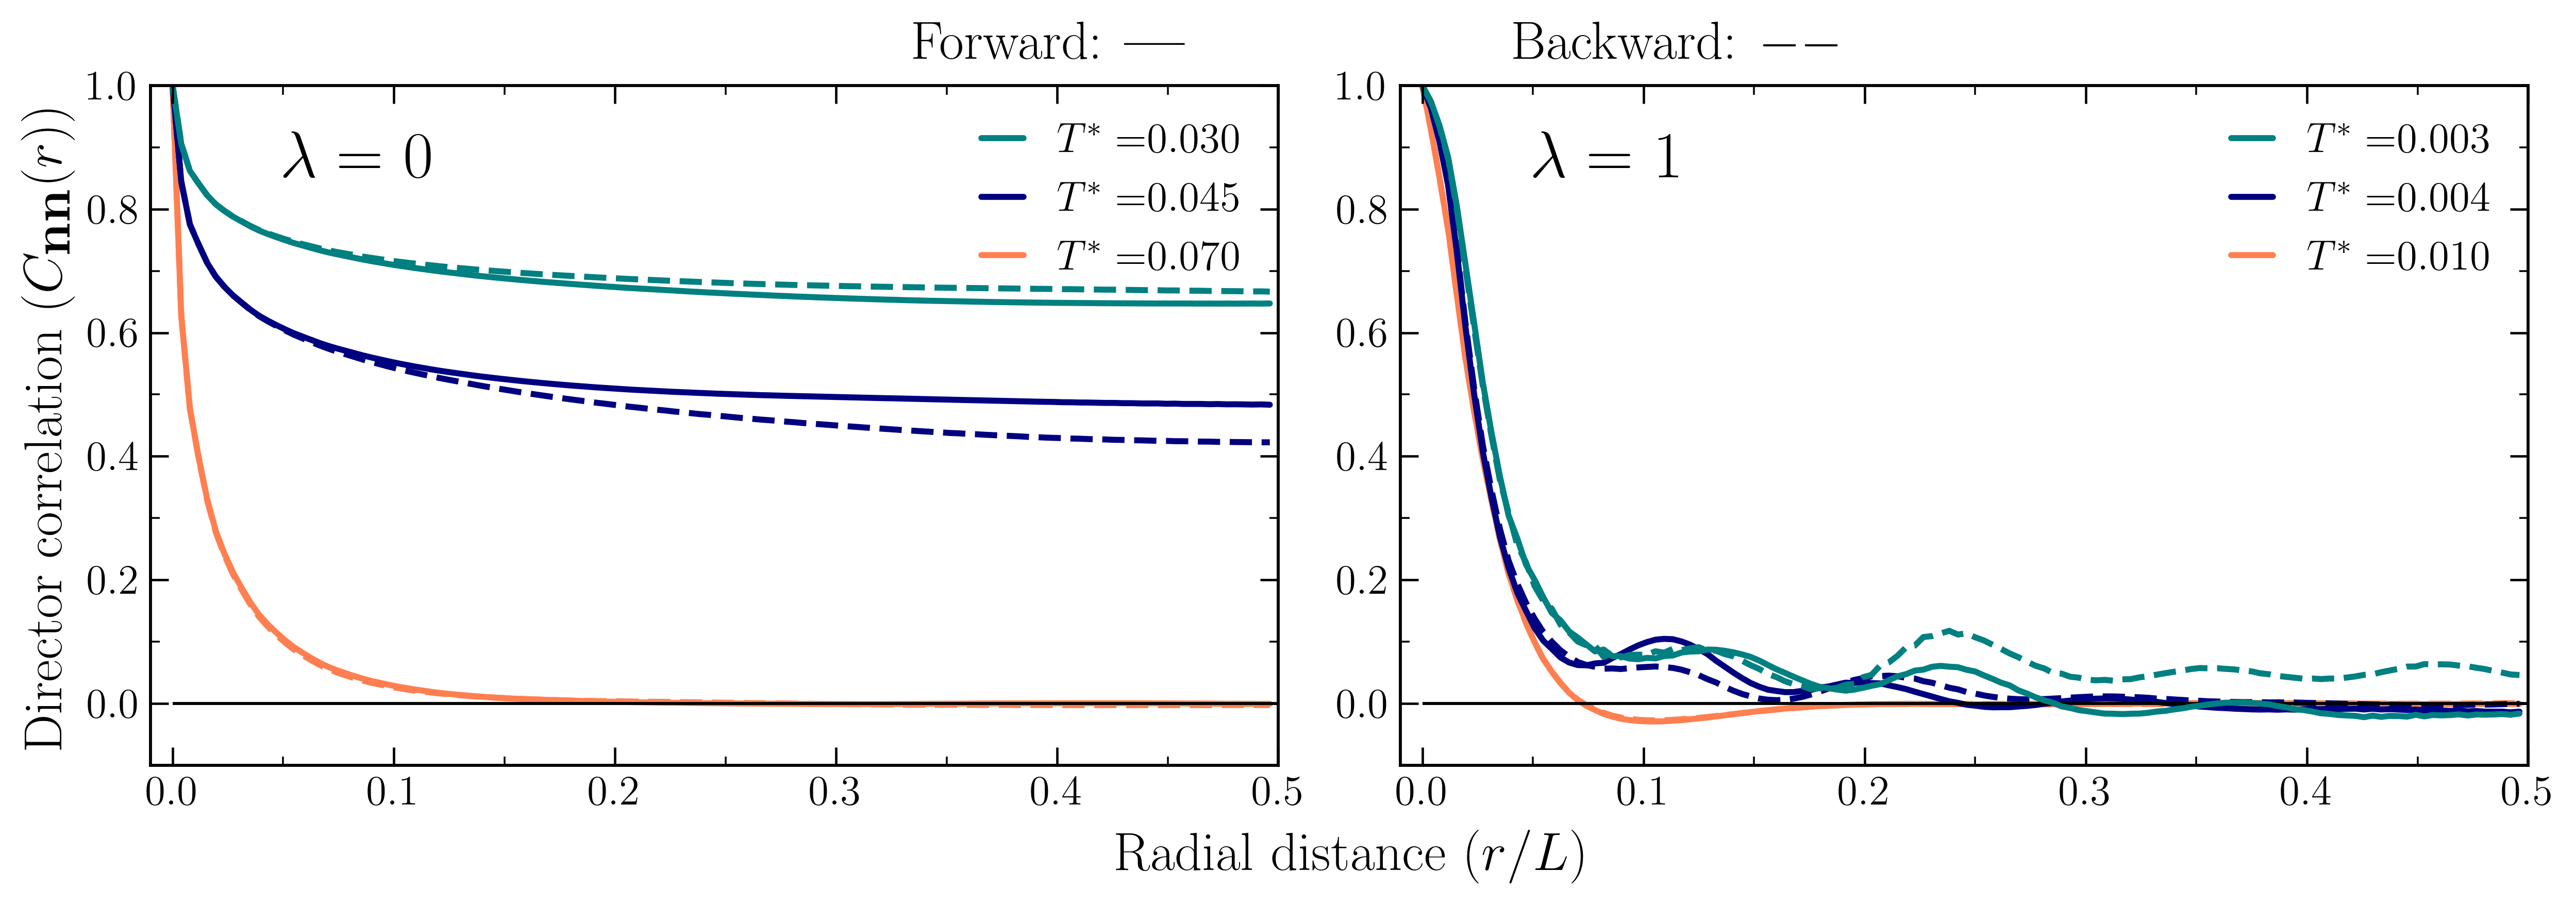

In [ ]:
#### DIRECTOR CORRELATION PLOT ####
plt.rcParams.update({"text.usetex": True, "legend.fontsize": 14, 
                     "legend.handlelength": 0,
                     })

fig, ax = plt.subplots(ncols=2,figsize=(12, 4.5))
ax = ax.flatten()
normalize=True
marker_list = ['dotted', 'dashed', 'dashdot']
ninfo = 1000

for i, lambda_val in enumerate([0, 1]):
    #mode = 'wet'
    normalizer = LX if normalize else 1
    out_path_all = os.path.join(data_dir, f'{folder_name}\\{mode}\\na{LX}')
    out_path_main = os.path.join(out_path_all, f'{lambda_val}')
    out_path_fwd = os.path.join(out_path_main, 'fwd')
    out_path_bck = os.path.join(out_path_main, 'bck')

    act_include_list = [0.03, 0.045, 0.07] if lambda_val == 0 else [.003, 0.004, 0.01]
    act_idx_fwd_include_list = [3, -6, -2,]# -1]

    act_bck = np.load(os.path.join(out_path_bck, 'act_bck.npy'))
    act_fwd = np.load(os.path.join(out_path_fwd, 'act_fwd.npy'))
    rdf_arr_av_fwd = np.load(os.path.join(out_path_fwd, 'rdf_arr_av.npy'))
    rdf_arr_av_bck = np.load(os.path.join(out_path_bck, 'rdf_arr_av.npy'))
    rvals = np.load(os.path.join(out_path_fwd, 'rvals.npy'))
    act_bck = act_bck #[act_idx_bck_include_list]
    act_fwd = act_fwd #[act_idx_fwd_include_list]
    rdf_arr_av_fwd = rdf_arr_av_fwd #[act_idx_fwd_include_list]
    rdf_arr_av_bck = rdf_arr_av_bck #[act_idx_bck_include_list]
    for j, act in enumerate(act_include_list):
        try:
            act_idx_fwd = np.argwhere(act_fwd == act)[0][0]
            print(act_idx_bck, act)
            ax[i].plot(rvals/LX, rdf_arr_av_fwd[act_idx_fwd, 0,:],'-', color=f'C{j}',  
                       label = rf'$T^* = ${act:.3f}',
                       zorder = -j)
        except:
            pass
        try:
            act_idx_bck = np.argwhere(act_bck == act)[0][0]
            ax[i].plot(rvals/LX, rdf_arr_av_bck[act_idx_bck, 0,:],ls='dashed', color=f'C{j}',zorder = -j)# label = rf'$T^* = ${act:.3f}' if j==0 else None) # $~~~~~~~~~\hspace{5em}$' if i==0 else None)# label=r'$\overline{l_{perc}}$')
        except:
            pass

    ax[i].legend(fontsize=14, loc='upper right', handlelength=1, ncol=1) #if i==0 else None)
    ax[i].set_ylim([-0.1, 1])
    ax[i].set_xlim([-.01, .5])
    ax[i].hlines(0, 0, .5, color='black', lw=1, zorder=-1)
    ax[i].text(0.05, 0.85, rf'$\lambda = ~${lambda_val}', fontsize=22) # transform=ax[i].transAxes, fontsize=22)
    ax[i].yaxis.set_minor_locator(ticker.MultipleLocator(0.1))
    ax[i].xaxis.set_minor_locator(ticker.MultipleLocator(5e-2))
ax[0].set_ylabel(r'Director correlation ($C_{\textbf{nn}} (r)$)')
fig.supxlabel(r'Radial distance ($r/L$)',x=.525,y=0.05)
#
# fig.suptitle(r'Solid: Forward ~~~~~~~~~~~~~~~~~~ Dashed: Backward', fontsize=18, x=.535,y=.935,)# bbox_to_anchor=(0.5, 1.02))#, bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white')) 
fig.suptitle(r'Forward: $\textbf{---}$ ~~~~~~~~~~~~~~~~~~ Backward: $--$', fontsize=18, x=.535,y=.935,)
#ax[1].set_yscale('log')
for n, AXX in enumerate(ax):
    AXX.tick_params(axis='both',which='major', labelsize=14 if n==0 else 14)

fig.tight_layout()
save_path = os.path.join(out_path_all, 'figs')
if not os.path.isdir(save_path):
    os.makedirs(save_path)
if save_figs:
    fig.savefig(os.path.join(save_path, f'correlation.png'), bbox_inches='tight', dpi=520, pad_inches=.1)
    fig.savefig(os.path.join(figpath_article, f'correlation.png'), bbox_inches='tight', dpi=520, pad_inches=.1) 
    print('Saved figure to', os.path.join(figpath_article, f'correlation.png'))

0.004 0.004
0.004 0.004


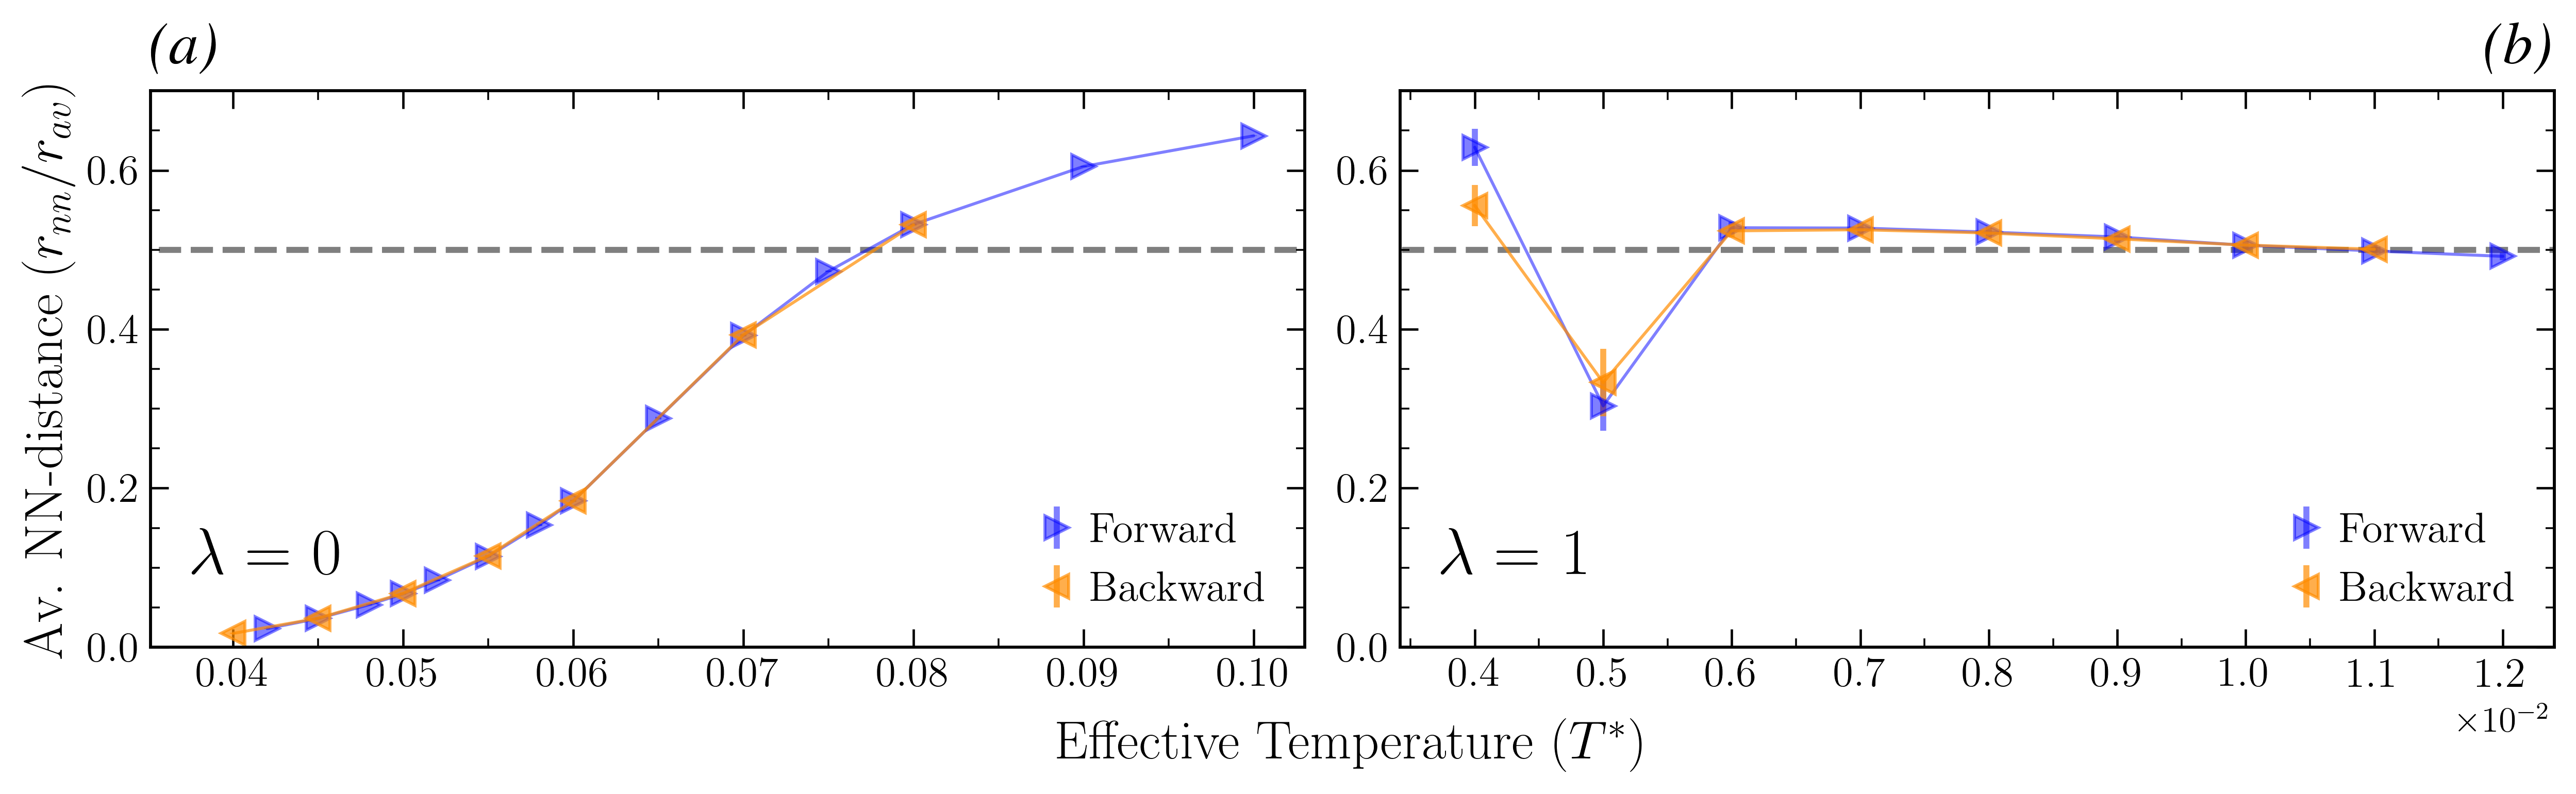

In [28]:
### Passive RNN plot ###

plt.rcParams.update({"text.usetex": True, "legend.fontsize": 14, 
                     "legend.handlelength": 0,})

fig, ax = plt.subplots(ncols=2,figsize=(12, 4.))
ax = ax.flatten()
normalize=True
marker_list = ['dotted', 'dashed', 'dashdot']
ninfo = 1000

act_fwd_replace_list = [[], [0.004]]
act_bck_replace_list = [[], [0.004]]
act_fwd_min_list = [0.04,0.004]
act_bck_min_list = [0.04,0.004]
act_fwd_exl_list = [[], []] #[0.005]]
act_bck_exl_list = [[], []]

for i, lambda_val in enumerate(lambda_list):
   # mode = 'wet'
    normalizer = LX if normalize else 1
    out_path_all = os.path.join(data_dir, f'{folder_name}\\{mode}\\na{LX}')
    out_path_all_wet = os.path.join(data_dir, f'diff_lambda_periodic\\wet\\na{LX}')
    out_path_main = os.path.join(out_path_all, f'{lambda_val}')
    out_path_fwd = os.path.join(out_path_main, 'fwd')
    out_path_bck = os.path.join(out_path_main, 'bck')

    act_bck = np.load(os.path.join(out_path_bck, 'act_bck.npy'))
    act_fwd = np.load(os.path.join(out_path_fwd, 'act_fwd.npy'))
    def_arr_bck = np.load(os.path.join(out_path_bck, 'def_arr.npy'))
    def_arr_fwd = np.load(os.path.join(out_path_fwd, 'def_arr.npy'))
    nn_arr_av_fwd = np.load(os.path.join(out_path_fwd, 'nn_av.npy'))
    nn_arr_av_bck = np.load(os.path.join(out_path_bck, 'nn_av.npy'))

    out_path_main_wet = os.path.join(out_path_all_wet, f'{lambda_val}')
    out_path_fwd_wet = os.path.join(out_path_main_wet, 'fwd')
    out_path_bck_wet = os.path.join(out_path_main_wet, 'bck')
    act_bck_wet = np.load(os.path.join(out_path_bck_wet, 'act_bck.npy'))
    act_fwd_wet = np.load(os.path.join(out_path_fwd_wet, 'act_fwd.npy'))
    nn_arr_av_fwd_wet = np.load(os.path.join(out_path_fwd_wet, 'nn_av.npy'))
    nn_arr_av_bck_wet = np.load(os.path.join(out_path_bck_wet, 'nn_av.npy'))

    # apply replacements on nn_arr_av
    for act_replace in act_fwd_replace_list[i]:
        if act_replace in act_fwd:
            act_idx = np.argwhere(act_fwd == act_replace)[0][0]
            act_idx_wet = np.argwhere(act_fwd_wet == act_replace)[0][0]
         #   print(act_fwd[act_idx], act_fwd_wet[act_idx_wet])
            nn_arr_av_fwd[act_idx,:] = nn_arr_av_fwd_wet[act_idx_wet,:]
    for act_replace in act_bck_replace_list[i]:
        if act_replace in act_bck:
            act_idx = np.argwhere(act_bck == act_replace)[0][0]
            act_idx_wet = np.argwhere(act_bck_wet == act_replace)[0][0]
        #    print(act_bck[act_idx], act_bck_wet[act_idx_wet])
            nn_arr_av_bck[act_idx,:] = nn_arr_av_bck_wet[act_idx_wet,:]

    # make activity masks 
    act_fwd_mask = (act_fwd >=  act_fwd_min_list[i])
    act_bck_mask = (act_bck >=  act_bck_min_list[i])
    for act_excl in act_fwd_exl_list[i]:
        if act_excl in act_fwd:
            act_idx = np.argwhere(act_fwd == act_excl)[0][0]
            act_fwd_mask[act_idx] = False
    for act_excl in act_bck_exl_list[i]:
        if act_excl in act_bck:
            act_idx = np.argwhere(act_bck == act_excl)[0][0]
            act_bck_mask[act_idx] = False

    ax[i].errorbar(act_fwd[act_fwd_mask], nn_arr_av_fwd[act_fwd_mask,0], yerr=nn_arr_av_fwd[act_fwd_mask,1], alpha=.5,ms=8,fmt='b>-', label=r'Forward', lw=1, elinewidth=2)# if i==0 else None)#$\overline{l_{max}}$ (Forward)' if i==0 else None)# label=r'$\overline{l_{max}}$')
    ax[i].errorbar(act_bck[act_bck_mask], nn_arr_av_bck[act_bck_mask,0], yerr=nn_arr_av_bck[act_bck_mask,1], fmt='<-',color='darkorange', alpha=.7, ms=8,lw=1, elinewidth=2, label=r'Backward')#  if i==0 else None) # $~~~~~~~~~\hspace{5em}$' if i==0 else None)# label=r'$\overline{l_{perc}}$')

    ax[i].set_ylim([0, .7])#0.8))
   # ax[i].set_xlim([-2.5e-3 if i==0 else -2.5e-4, max(act_fwd[-1], act_bck[-1]) + 2.5e-3 if i==0 \
    #                else max(act_fwd[-1], act_bck[-1]) + 2.5e-4])
    ax[i].set_xlim(ax[i].get_xlim()[0]*0.95, ax[i].get_xlim()[1])

    ax[i].yaxis.set_minor_locator(ticker.MultipleLocator(0.05))
    ax[i].xaxis.set_minor_locator(ticker.MultipleLocator(0.005 if i==0 else 0.0005))
    ax[i].hlines(0.5, -.12,.12, linestyle='--', color='black', alpha=0.5,)

    ax[i].legend(fontsize=14, loc='lower right',) # handlelength=1, ncol=1) #if i==0 else None)
    ax[i].text(0.035, 0.13, rf'$\lambda = ~${lambda_val}', transform=ax[i].transAxes, fontsize=22)
    

ax[0].set_ylabel(r'Av. NN-distance ($r_{nn}/r_{av}$)')
fig.supxlabel(r'Effective Temperature ($T^*$)',x=.525,y=0.095)

for n, AXX in enumerate(ax):
    n0 = 0
    AXX.tick_params(axis='both',which='major', labelsize=14 if n==0 else 14)
    AXX.text(0.0 if n==0 else 0.94, 1.05, rf"{{\fontfamily{{ntxtlf}}\selectfont\textit{{({string.ascii_lowercase[n]})}}}}", transform=AXX.transAxes,
            size=20,  weight='normal',fontstyle='italic',fontfamily="Times New Roman", color = 'black' if letter_subfigs else 'white',)

fig.tight_layout()
save_path = os.path.join(out_path_all, 'figs')
if not os.path.isdir(save_path):
    os.makedirs(save_path)

if save_figs:
    fig.savefig(os.path.join(save_path, f'rnn_av_v4{"_unlabeled" if not letter_subfigs else ""}.png'), dpi=720, bbox_inches='tight', pad_inches=.035)
    fig.savefig(os.path.join(figpath_article, f'rnn_av_v4{"_unlabeled" if not letter_subfigs else ""}.png'), dpi=720, bbox_inches='tight', pad_inches=.035) 
    print("Saved figure to ", os.path.join(save_path, f'rnn_av_v4{"_unlabeled" if not letter_subfigs else ""}.png'))

In [ ]:
### Passive RNN time series plot ###

plt.rcParams.update({"text.usetex": True, "legend.fontsize": 14, 
                     "legend.handlelength": 0,
                     })

fig, ax = plt.subplots(ncols=2,figsize=(12, 4.))
ax = ax.flatten()
normalize=True
marker_list = ['dotted', 'dashed', 'dashdot']
marker_list_l0=['.','*','x']
ninfo = 1000

act_fwd_replace_list = [[], [0.004]]
act_bck_replace_list = [[], [0.004]]
act_fwd_min_list = [0.04,0.004]
act_bck_min_list = [0.04,0.004]
act_fwd_exl_list = [[], [0.005]]
act_bck_exl_list = [[], []]

for i, lambda_val in enumerate(lambda_list):
   # mode = 'wet'
    normalizer = LX if normalize else 1
    out_path_all = os.path.join(data_dir, f'{folder_name}\\{mode}\\na{LX}')
    out_path_all_wet = os.path.join(data_dir, f'diff_lambda_periodic\\wet\\na{LX}') 
    
    out_path_main = os.path.join(out_path_all, f'{lambda_val}')
    out_path_fwd = os.path.join(out_path_main, 'fwd')
    out_path_bck = os.path.join(out_path_main, 'bck')

    act_bck = np.load(os.path.join(out_path_bck, 'act_bck.npy'))
    act_fwd = np.load(os.path.join(out_path_fwd, 'act_fwd.npy'))
    nn_arr_fwd = np.load(os.path.join(out_path_fwd, 'nn_arr.npy'))
    nn_arr_bck = np.load(os.path.join(out_path_bck, 'nn_arr.npy'))
    def_arr_bck = np.load(os.path.join(out_path_bck, 'def_arr.npy'))
    def_arr_fwd = np.load(os.path.join(out_path_fwd, 'def_arr.npy'))

    out_path_main_wet = os.path.join(out_path_all_wet, f'{lambda_val}')
    out_path_fwd_wet = os.path.join(out_path_main_wet, 'fwd')
    out_path_bck_wet = os.path.join(out_path_main_wet, 'bck')
    act_bck_wet = np.load(os.path.join(out_path_bck_wet, 'act_bck.npy'))
    act_fwd_wet = np.load(os.path.join(out_path_fwd_wet, 'act_fwd.npy'))
    nn_arr_fwd_wet = np.load(os.path.join(out_path_fwd_wet, 'nn_arr.npy'))
    nn_arr_bck_wet = np.load(os.path.join(out_path_bck_wet, 'nn_arr.npy'))
    def_arr_bck_wet = np.load(os.path.join(out_path_bck_wet, 'def_arr.npy'))
    def_arr_fwd_wet = np.load(os.path.join(out_path_fwd_wet, 'def_arr.npy'))

    nacts=len(marker_list)
    act_include_list = [0.045,0.055,0.05] if lambda_val == 0 else [0.004,0.005]

    for j, temp in enumerate(act_include_list):
        if temp in act_bck_replace_list[i]:
            act_replace = temp
            act_idx_wet = np.argwhere(act_bck_wet == act_replace)[0][0]
            rnn_arr = nn_arr_bck_wet[:,0,act_idx_wet,]
            defect_arr = def_arr_bck_wet[:,act_idx_wet,]
            print("Using wet data for", temp)
        else:
            actidx = np.argwhere(act_bck == temp)[0][0]
            rnn_arr = nn_arr_bck[:,0,actidx,]
            defect_arr = def_arr_bck[:,actidx,]
        mask_bck = rnn_arr > 0
        normalizer = LX / np.sqrt(defect_arr[mask_bck]) if normalize else 1# LX
        xvals = np.arange(0, Nframes * ninfo, ninfo)[mask_bck]

        if i == 0:
            kwargs = dict(lw=0, ms=4, alpha=.4, marker=marker_list_l0[j%len(marker_list_l0)])
        else:
            kwargs = dict(ls=marker_list[j%len(marker_list)], alpha=.8)

        ax[i].plot(xvals, rnn_arr[mask_bck] / normalizer, **kwargs,  label = rf'$T^*$$=${temp:.3f}')
        ax[i].legend(ncols=2, loc='upper left' if i==1 else 'upper right',
                     fontsize=14, handlelength=1, columnspacing=1, markerscale=2 if i==0 else 1)# if j==2 else 1)   

    ###############################################################################
    xticks = [0, 2e5, 4e5, 6e5, 8e5,10e5]
    xticks_labels = ['0', '2', '4', '6', '8', '10']
    ax[i].set_xticks(xticks, xticks_labels)
    ax[i].text(0.035, 0.13 if i==1 else 0.85, rf'$\lambda = ~${lambda_val} (Backward)', transform=ax[i].transAxes, fontsize=22)
    ax[i].set_xlim([0, 1e6+1e4])
    ax[i].xaxis.set_minor_locator(ticker.MultipleLocator(1e5))
    ax[i].yaxis.set_minor_locator(ticker.MultipleLocator(0.1 if i==1 else 0.05))

for n, AXX in enumerate(ax):
    n0 = 2
    AXX.tick_params(axis='both',which='major', labelsize=14 if n==0 else 14)
    AXX.text(0 if n==0 else .94, 1.05, rf"{{\fontfamily{{ntxtlf}}\selectfont\textit{{({string.ascii_lowercase[n0+n]})}}}}", transform=AXX.transAxes,
            size=20,  weight='normal',fontstyle='italic',fontfamily="Times New Roman", color = 'black' if letter_subfigs else 'white',)
    AXX.set_ylim(ymin=0, ymax=0.21 if n==0 else 0.84)

yticks = [0, 0.1, 0.2]
ax[0].set_yticks(yticks)

ax[0].set_ylabel(r'NN-distance ($r_{nn}(t)/r_{av}(t)$)')
fig.supxlabel(r'Time step ($10^5$)',x=.525,y=0.075)
fig.tight_layout()
save_path = os.path.join(out_path_all, 'figs')
if not os.path.isdir(save_path):
    os.makedirs(save_path)

if save_figs:
    fig.savefig(os.path.join(save_path, f'rnn_time_v4{"_unlabeled" if not letter_subfigs else ""}.png'), dpi=720, bbox_inches='tight', pad_inches=.035)
    fig.savefig(os.path.join(figpath_article, f'rnn_time_v4{"_unlabeled" if not letter_subfigs else ""}.png'), dpi=720, bbox_inches='tight', pad_inches=.035) 
    print("Saved figure to ", os.path.join(save_path, f'rnn_time_v4{"_unlabeled" if not letter_subfigs else ""}.png'))

In [ ]:
### Passive RNN plot ###
normalize=True
ninfo = 1000
L_list = [256]

lambda_val = 1
normalize=True
plot_backwards=True


i = lambda_val
fig_num = 3
fig_let = 'e' if i==0 else 'f' #string.ascii_lowercase[i]

xval_name = 'effective_temp'
csv_save_path = os.path.join(research_dir, 'DefectUnbinding', 'Data', f'{mode}', f'fig{fig_num}{fig_let}.csv')
os.makedirs(os.path.dirname(csv_save_path), exist_ok=True)

out_path_main = os.path.join(out_path_all, f'{lambda_val}')
out_path_fwd = os.path.join(out_path_main, 'fwd')
out_path_bck = os.path.join(out_path_main, 'bck')

act_fwd_replace_list = [[], [0.004]]
act_bck_replace_list = [[], [0.004]]
act_fwd_min_list = [0.04,0.004]
act_bck_min_list = [0.04,0.004]
act_fwd_exl_list = [[], []] #[0.005]]
act_bck_exl_list = [[], []]

act_bck = np.load(os.path.join(out_path_bck, 'act_bck.npy'))
act_fwd = np.load(os.path.join(out_path_fwd, 'act_fwd.npy'))
lmax_av_fwd = np.load(os.path.join(out_path_fwd, 'lmax_av.npy')) / normalizer
lperc_av_fwd = np.load(os.path.join(out_path_fwd, 'lperc_av.npy')) / normalizer
lmax_av_bck = np.load(os.path.join(out_path_bck, 'lmax_av.npy')) / normalizer
lperc_av_bck = np.load(os.path.join(out_path_bck, 'lperc_av.npy')) / normalizer
nn_arr_fwd = np.load(os.path.join(out_path_fwd, 'nn_arr.npy'))
nn_arr_bck = np.load(os.path.join(out_path_bck, 'nn_arr.npy'))
def_arr_bck = np.load(os.path.join(out_path_bck, 'def_arr.npy'))
def_arr_fwd = np.load(os.path.join(out_path_fwd, 'def_arr.npy'))

out_path_main_wet = os.path.join(out_path_all_wet, f'{lambda_val}')
out_path_fwd_wet = os.path.join(out_path_main_wet, 'fwd')
out_path_bck_wet = os.path.join(out_path_main_wet, 'bck')
act_bck_wet = np.load(os.path.join(out_path_bck_wet, 'act_bck.npy'))
act_fwd_wet = np.load(os.path.join(out_path_fwd_wet, 'act_fwd.npy'))
lperc_av_fwd_wet = np.load(os.path.join(out_path_fwd_wet, 'lperc_av.npy')) / normalizer
lmax_av_fwd_wet = np.load(os.path.join(out_path_fwd_wet, 'lmax_av.npy')) / normalizer
lperc_av_bck_wet = np.load(os.path.join(out_path_bck_wet, 'lperc_av.npy')) / normalizer
lmax_av_bck_wet = np.load(os.path.join(out_path_bck_wet, 'lmax_av.npy')) / normalizer

 # apply replacements on nn_arr_av
for act_replace in act_fwd_replace_list[i]:
    if act_replace in act_fwd:
        act_idx = np.argwhere(act_fwd == act_replace)[0][0]
        act_idx_wet = np.argwhere(act_fwd_wet == act_replace)[0][0]
        print(act_fwd[act_idx], act_fwd_wet[act_idx_wet])
        lperc_av_fwd[act_idx,:] = lperc_av_fwd_wet[act_idx_wet,:]
        lmax_av_fwd[act_idx,:] = lmax_av_fwd_wet[act_idx_wet,:]
for act_replace in act_bck_replace_list[i]:
    if act_replace in act_bck:
        act_idx = np.argwhere(act_bck == act_replace)[0][0]
        act_idx_wet = np.argwhere(act_bck_wet == act_replace)[0][0]
        print(act_bck[act_idx], act_bck_wet[act_idx_wet])
        lperc_av_bck[act_idx,:] = lperc_av_bck_wet[act_idx_wet,:]
        lmax_av_bck[act_idx,:] = lmax_av_bck_wet[act_idx_wet,:]

# make activity masks 
act_fwd_mask = (act_fwd >=  act_fwd_min_list[i])
act_bck_mask = (act_bck >=  act_bck_min_list[i])
for act_excl in act_fwd_exl_list[i]:
    if act_excl in act_fwd:
        act_idx = np.argwhere(act_fwd == act_excl)[0][0]
        act_fwd_mask[act_idx] = False
for act_excl in act_bck_exl_list[i]:
    if act_excl in act_bck:
        act_idx = np.argwhere(act_bck == act_excl)[0][0]
        act_bck_mask[act_idx] = False

temp_list_fwd = act_fwd[act_fwd_mask]
temp_list_bck = act_bck[act_bck_mask]
#temp_list_fwd.append(act_fwd[act_fwd_mask])
lmax_fwd = lmax_av_fwd[act_fwd_mask,:]
lmax_bck = lmax_av_bck[act_bck_mask,:]
lperc_fwd = lperc_av_fwd[act_fwd_mask,:]
lperc_bck = lperc_av_bck[act_bck_mask,:]

print(lperc_fwd.shape, lperc_bck.shape)

#print(act_fwd[act_fwd_mask], act_bck[act_bck_mask])
temp_list_tot = np.unique(np.concatenate((act_fwd[act_fwd_mask], act_bck[act_bck_mask]))) if plot_backwards else np.unique(act_fwd[act_fwd_mask])
xval_name= 'effective_temp'

df = pd.DataFrame(index=temp_list_tot)
# name index
df.index.name = xval_name

for j, (direc, temp_list_dir, yval_list_dir) in enumerate(zip(['fwd', 'bck'], [temp_list_fwd, temp_list_bck], [lperc_fwd, lperc_bck ])):
    if direc == 'bck' and not plot_backwards:
        continue
    # extend temp_list_dir to total temp list
    temp_mask_ext = False * np.ones_like(temp_list_tot, dtype=bool)
    # if temp in temp_list_fwd[j], set mask to True
    for k, temp in enumerate(temp_list_tot):
        if temp in temp_list_dir:
            temp_mask_ext[k] = True
    col_name_av = f'lperc_av_{direc}'
    col_name_std = f'lperc_sem_{direc}'
  #  print(temp_list_tot, temp_list_dir, yval_list_dir.shape)
  #  print(temp_mask_ext.sum())
    df[col_name_av] = np.nan
    df[col_name_std] = np.nan
    df.loc[temp_mask_ext, col_name_av] = yval_list_dir[:,0]
    df.loc[temp_mask_ext, col_name_std] = yval_list_dir[:,1]

for j, (direc, temp_list_dir, yval_list_dir) in enumerate(zip(['fwd', 'bck'], [temp_list_fwd, temp_list_bck], [lmax_fwd, lmax_bck ])):
    if direc == 'bck' and not plot_backwards:
        continue
    # extend temp_list_dir to total temp list
    temp_mask_ext = False * np.ones_like(temp_list_tot, dtype=bool)
    # if temp in temp_list_fwd[j], set mask to True
    for k, temp in enumerate(temp_list_tot):
        if temp in temp_list_dir:
            temp_mask_ext[k] = True
    col_name_av = f'lmax_av_{direc}'
    col_name_std = f'lmax_sem_{direc}'
   # print(temp_list_tot, temp_list_dir, yval_list_dir.shape)
   # print(temp_mask_ext.sum())
    df[col_name_av] = np.nan
    df[col_name_std] = np.nan
    df.loc[temp_mask_ext, col_name_av] = yval_list_dir[:,0]
    df.loc[temp_mask_ext, col_name_std] = yval_list_dir[:,1]

# set dtype to float 
df = df.astype(float)
df.to_csv(csv_save_path)
print('Saved csv to', csv_save_path)
df.head(15)

0.004 0.004
0.004 0.004
Saved figure to  C:\Users\Simon Andersen\Projects\Projects\Thesis\NematicAnalysis\data\passive\diff_lambda_periodic\wet\na512\figs\lmax_lperc_v4.png


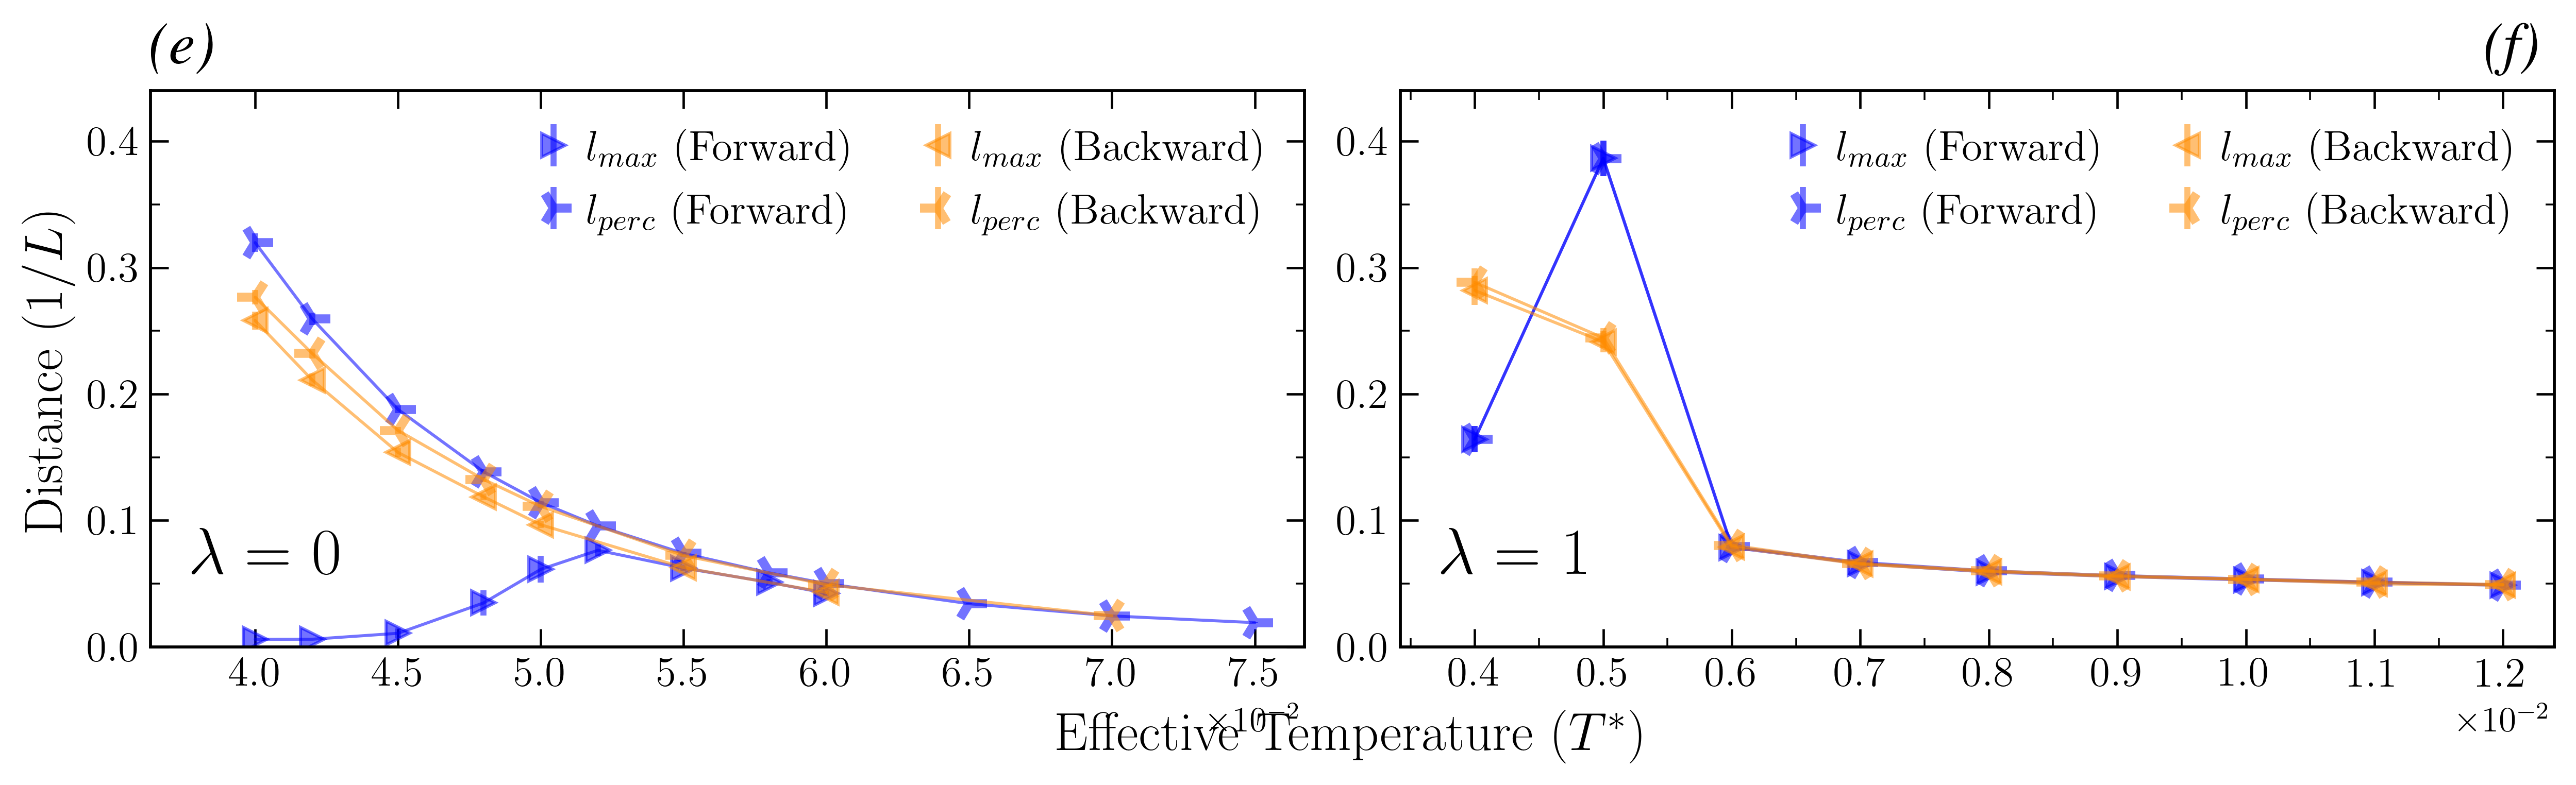

In [ ]:
### Passive lmax, lperc plot ###

plot_bck = True

plt.rcParams.update({"text.usetex": True, "legend.fontsize": 14, 
                     "legend.handlelength": 0,
                     })

fig, ax = plt.subplots(ncols=2, figsize=(12, 4))
ax = ax.flatten()
normalize=True
marker_list = ['dotted', 'dashed', 'dashdot']


act_fwd_replace_list = [[], [0.004]]
act_bck_replace_list = [[], [0.004]]
act_fwd_min_list = [0.04,0.004]
act_bck_min_list = [0.04,0.004]
act_fwd_exl_list = [[], []] #[0.005]]
act_bck_exl_list = [[], []]

for i, lambda_val in enumerate(lambda_list):
   # mode = 'wet'
    normalizer = LX if normalize else 1
    out_path_all = os.path.join(data_dir, f'{folder_name}\\{mode}\\na{LX}')
    out_path_all_wet = os.path.join(data_dir, f'diff_lambda_periodic\\wet\\na{LX}')

    out_path_main = os.path.join(out_path_all, f'{lambda_val}')
    out_path_fwd = os.path.join(out_path_main, 'fwd')
    out_path_bck = os.path.join(out_path_main, 'bck')

    act_bck = np.load(os.path.join(out_path_bck, 'act_bck.npy'))
    act_fwd = np.load(os.path.join(out_path_fwd, 'act_fwd.npy'))
    lmax_av_fwd = np.load(os.path.join(out_path_fwd, 'lmax_av.npy')) / normalizer
    lperc_av_fwd = np.load(os.path.join(out_path_fwd, 'lperc_av.npy')) / normalizer
    lmax_av_bck = np.load(os.path.join(out_path_bck, 'lmax_av.npy')) / normalizer
    lperc_av_bck = np.load(os.path.join(out_path_bck, 'lperc_av.npy')) / normalizer
    nn_arr_fwd = np.load(os.path.join(out_path_fwd, 'nn_arr.npy'))
    nn_arr_bck = np.load(os.path.join(out_path_bck, 'nn_arr.npy'))
    def_arr_bck = np.load(os.path.join(out_path_bck, 'def_arr.npy'))
    def_arr_fwd = np.load(os.path.join(out_path_fwd, 'def_arr.npy'))

    out_path_main_wet = os.path.join(out_path_all_wet, f'{lambda_val}')
    out_path_fwd_wet = os.path.join(out_path_main_wet, 'fwd')
    out_path_bck_wet = os.path.join(out_path_main_wet, 'bck')
    act_bck_wet = np.load(os.path.join(out_path_bck_wet, 'act_bck.npy'))
    act_fwd_wet = np.load(os.path.join(out_path_fwd_wet, 'act_fwd.npy'))
    lperc_av_fwd_wet = np.load(os.path.join(out_path_fwd_wet, 'lperc_av.npy')) / normalizer
    lmax_av_fwd_wet = np.load(os.path.join(out_path_fwd_wet, 'lmax_av.npy')) / normalizer
    lperc_av_bck_wet = np.load(os.path.join(out_path_bck_wet, 'lperc_av.npy')) / normalizer
    lmax_av_bck_wet = np.load(os.path.join(out_path_bck_wet, 'lmax_av.npy')) / normalizer
    

    # apply replacements on nn_arr_av
    for act_replace in act_fwd_replace_list[i]:
        if act_replace in act_fwd:
            act_idx = np.argwhere(act_fwd == act_replace)[0][0]
            act_idx_wet = np.argwhere(act_fwd_wet == act_replace)[0][0]
            print(act_fwd[act_idx], act_fwd_wet[act_idx_wet])
            lperc_av_fwd[act_idx,:] = lperc_av_fwd_wet[act_idx_wet,:]
            lmax_av_fwd[act_idx,:] = lmax_av_fwd_wet[act_idx_wet,:]
    for act_replace in act_bck_replace_list[i]:
        if act_replace in act_bck:
            act_idx = np.argwhere(act_bck == act_replace)[0][0]
            act_idx_wet = np.argwhere(act_bck_wet == act_replace)[0][0]
            print(act_bck[act_idx], act_bck_wet[act_idx_wet])
            lperc_av_bck[act_idx,:] = lperc_av_bck_wet[act_idx_wet,:]
            lmax_av_bck[act_idx,:] = lmax_av_bck_wet[act_idx_wet,:]

    # make activity masks 
    act_fwd_mask = (act_fwd >=  act_fwd_min_list[i])
    act_bck_mask = (act_bck >=  act_bck_min_list[i])
    for act_excl in act_fwd_exl_list[i]:
        if act_excl in act_fwd:
            act_idx = np.argwhere(act_fwd == act_excl)[0][0]
            act_fwd_mask[act_idx] = False
    for act_excl in act_bck_exl_list[i]:
        if act_excl in act_bck:
            act_idx = np.argwhere(act_bck == act_excl)[0][0]
            act_bck_mask[act_idx] = False

    
    ax[i].errorbar(act_fwd[act_fwd_mask], lmax_av_fwd[act_fwd_mask,0], yerr=lmax_av_fwd[act_fwd_mask,1],
                   alpha=.55,ms=8,fmt='>-',color='blue', lw=1, elinewidth=2,
                   label=r'$l_{max}$ (Forward)')
    ax[i].errorbar(act_fwd[act_fwd_mask], lperc_av_fwd[act_fwd_mask,0], yerr=lperc_av_fwd[act_fwd_mask,1], 
                   alpha=.55,ms=12, fmt='4-',color='blue', mew=3, lw=1, elinewidth=2,
                   label=r'$l_{perc}$ (Forward)')

    if plot_bck:
        ax[i].errorbar(act_bck[act_bck_mask], lmax_av_bck[act_bck_mask,0], yerr=lmax_av_bck[act_bck_mask,1],
                       alpha=.55, ms=8,fmt='<-',color='darkorange',lw=1, elinewidth=2,
                       label=r'$l_{max}$ (Backward)')
        ax[i].errorbar(act_bck[act_bck_mask], lperc_av_bck[act_bck_mask,0], yerr=lperc_av_bck[act_bck_mask,1], 
                       ms=12,alpha=.55,fmt='3-', mew=3, color='darkorange',lw=1, elinewidth=2, 
                       label=r'$l_{perc}$ (Backward)')
        ax[i].yaxis.set_minor_locator(ticker.MultipleLocator(0.05))
        ax[i].xaxis.set_minor_locator(ticker.MultipleLocator(0.005 if i==0 else 0.0005))
    if not plot_bck:
        ax[i].yaxis.set_minor_locator(ticker.MultipleLocator(0.05))
        ax[i].xaxis.set_minor_locator(ticker.MultipleLocator(0.005 if i==0 else 0.0005))

  #  ax[i].set_ylim([0, .44])#0.8))
    ax[i].text(0.035, 0.13, rf'$\lambda =~${lambda_val}', transform=ax[i].transAxes, fontsize=22)

    ax[i].legend(fontsize=14, loc='upper right', handlelength=0, ncol=2) #if i==0 else None)

    ###############################################################################


ax[0].set_ylabel(r'Distance ($1/L$)')
fig.supxlabel(r'Effective Temperature ($T^*$)',x=0.525,y=.105)

labels = []
handles = []

for errorbar in ax[0].containers:  # Accessing all the containers (including ErrorbarContainer)
    labels.append(errorbar.get_label())
    handles.append(errorbar)


for n, AXX in enumerate(ax):
  n0=4
  AXX.tick_params(axis='both',which='major', labelsize=14 if n==0 else 14)
  AXX.text(0 if n==0 else .94, 1.05, rf"{{\fontfamily{{ntxtlf}}\selectfont\textit{{({string.ascii_lowercase[n0+n]})}}}}", transform=AXX.transAxes,
          size=20,  weight='normal',fontstyle='italic',fontfamily="Times New Roman", color = 'black' if letter_subfigs else 'white',)
  AXX.set_ylim([0,0.44])
  AXX.set_xlim(AXX.get_xlim()[0]*0.95, AXX.get_xlim()[1])
fig.tight_layout()
save_path = os.path.join(out_path_all, 'figs')
if not os.path.isdir(save_path):
    os.makedirs(save_path)

if save_figs:
    fig.savefig(os.path.join(save_path, f'lmax_lperc_v4{"_unlabeled" if not letter_subfigs else ""}.png'), dpi=720, bbox_inches='tight', pad_inches=.035)
    fig.savefig(os.path.join(figpath_article, f'lmax_lperc_v4{"_unlabeled" if not letter_subfigs else ""}.png'), dpi=720, bbox_inches='tight', pad_inches=.035) 
    print("Saved figure to ", os.path.join(save_path, f'lmax_lperc_v4{"_unlabeled" if not letter_subfigs else ""}.png'))

Make plots for L=128, 512 (possibly 256)

Saved figure to  C:\Users\Simon Andersen\Projects\Projects\Thesis\NematicAnalysis\data\passive\diff_lambda_periodic\wet\na512\figs\rnn_varL.pdf


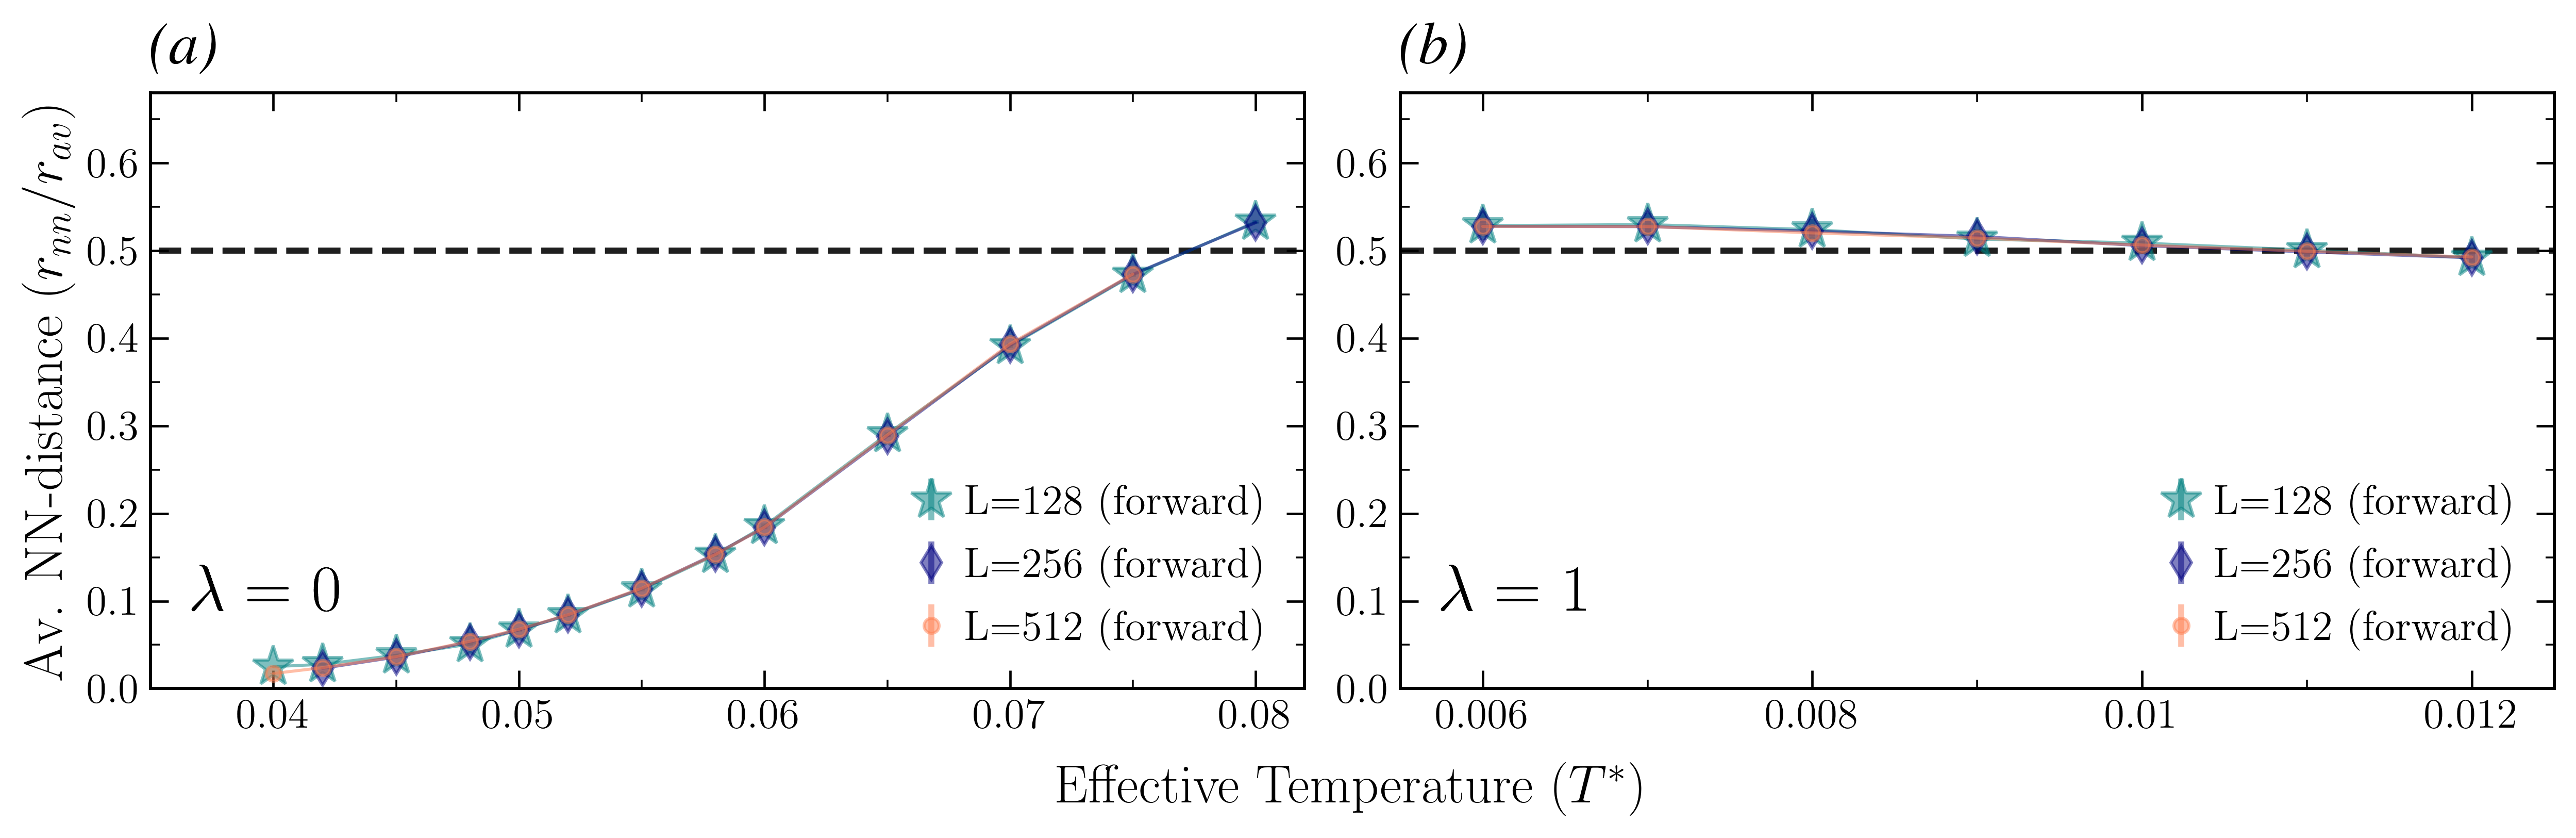

In [ ]:
### Passive RNN plot ###

plt.rcParams.update({"text.usetex": True, "legend.fontsize": 14, 
                     "legend.handlelength": 0,
                     })

normalize=True
marker_list = ['*', 'd', 'o']
ninfo = 1000
plot_backwards=False
xlims = [(0.035, 0.082), (0.0055, 0.0125)]
ylims = [(0, 0.68), (0, 0.68)]

L_list = [128,256,512]
nrows = 1
fig, ax = plt.subplots(nrows = nrows, ncols=2,figsize=(12, 4.))
ax = ax.flatten()

for j, LX in enumerate(L_list):

  #  fig, ax = plt.subplots(ncols=2,figsize=(12, 4.))
   # if j<2:continue
    if LX == 256:

        folder_name = 'diff_lambda_merge' 
        mode = 'wetmerge'
        act_fwd_replace_list = [[], [0.004]]
        act_bck_replace_list = [[], [0.004]]
    else:
        folder_name = 'diff_lambda_periodic'
        mode = 'wet'
        act_fwd_replace_list = [[],[]] # [[], [0.004]]
        act_bck_replace_list = [[],[]] #[[], [0.004]]
        
    act_fwd_min_list = [0.04,0.006]
    act_bck_min_list = [0.04,0.006]
    act_fwd_max_list = [0.082,0.012]
    act_bck_max_list = [0.082,0.012]
    act_fwd_exl_list = [[], []] #[0.005]]
    act_bck_exl_list = [[], []]

    for i, lambda_val in enumerate(lambda_list):
    # mode = 'wet'
        normalizer = LX if normalize else 1
        out_path_all = os.path.join(data_dir, f'{folder_name}\\{mode}\\na{LX}')
        out_path_all_wet = os.path.join(data_dir, f'diff_lambda_periodic\\wet\\na{LX}') 
        
        out_path_main = os.path.join(out_path_all, f'{lambda_val}')
        out_path_fwd = os.path.join(out_path_main, 'fwd')
        out_path_bck = os.path.join(out_path_main, 'bck')

        act_bck = np.load(os.path.join(out_path_bck, 'act_bck.npy'))
        act_fwd = np.load(os.path.join(out_path_fwd, 'act_fwd.npy'))
        def_arr_bck = np.load(os.path.join(out_path_bck, 'def_arr.npy'))
        def_arr_fwd = np.load(os.path.join(out_path_fwd, 'def_arr.npy'))
        nn_arr_av_fwd = np.load(os.path.join(out_path_fwd, 'nn_av.npy'))
        nn_arr_av_bck = np.load(os.path.join(out_path_bck, 'nn_av.npy'))

        out_path_main_wet = os.path.join(out_path_all_wet, f'{lambda_val}')
        out_path_fwd_wet = os.path.join(out_path_main_wet, 'fwd')
        out_path_bck_wet = os.path.join(out_path_main_wet, 'bck')
        act_bck_wet = np.load(os.path.join(out_path_bck_wet, 'act_bck.npy'))
        act_fwd_wet = np.load(os.path.join(out_path_fwd_wet, 'act_fwd.npy'))
        nn_arr_av_fwd_wet = np.load(os.path.join(out_path_fwd_wet, 'nn_av.npy'))
        nn_arr_av_bck_wet = np.load(os.path.join(out_path_bck_wet, 'nn_av.npy'))

        # apply replacements on nn_arr_av
        for act_replace in act_fwd_replace_list[i]:
            if act_replace in act_fwd:
                act_idx = np.argwhere(act_fwd == act_replace)[0][0]
                act_idx_wet = np.argwhere(act_fwd_wet == act_replace)[0][0]
           #     print(act_fwd[act_idx], act_fwd_wet[act_idx_wet])
                nn_arr_av_fwd[act_idx,:] = nn_arr_av_fwd_wet[act_idx_wet,:]
        for act_replace in act_bck_replace_list[i]:
            if act_replace in act_bck:
                act_idx = np.argwhere(act_bck == act_replace)[0][0]
                act_idx_wet = np.argwhere(act_bck_wet == act_replace)[0][0]
            #    print(act_bck[act_idx], act_bck_wet[act_idx_wet])
                nn_arr_av_bck[act_idx,:] = nn_arr_av_bck_wet[act_idx_wet,:]

        # make activity masks 
        act_fwd_mask = ((act_fwd >=  act_fwd_min_list[i]) & (act_fwd <=  act_fwd_max_list[i]))
        act_bck_mask = ((act_bck >=  act_bck_min_list[i]) & (act_bck <=  act_bck_max_list[i]))
        for act_excl in act_fwd_exl_list[i]:
            if act_excl in act_fwd:
                act_idx = np.argwhere(act_fwd == act_excl)[0][0]
                act_fwd_mask[act_idx] = False
        for act_excl in act_bck_exl_list[i]:
            if act_excl in act_bck:
                act_idx = np.argwhere(act_bck == act_excl)[0][0]
                act_bck_mask[act_idx] = False

        if LX==128: ms = 14
        elif LX==256: ms = 8
        else: ms = 5

        ax[i].errorbar(act_fwd[act_fwd_mask], nn_arr_av_fwd[act_fwd_mask,0], yerr=nn_arr_av_fwd[act_fwd_mask,1], alpha=.5,ms=ms,fmt=f'{marker_list[j]}-', label=rf'L={LX} (forward)', lw=1, elinewidth=2)# if i==0 else None)#$\overline{l_{max}}$ (Forward)' if i==0 else None)# label=r'$\overline{l_{max}}$')
        
        if plot_backwards:
            ax[i].errorbar(act_bck[act_bck_mask], nn_arr_av_bck[act_bck_mask,0], yerr=nn_arr_av_bck[act_bck_mask,1], fmt='<-',color='darkorange', alpha=.7, ms=8,lw=1, elinewidth=2, label=r'Backward')#  if i==0 else None) # $~~~~~~~~~\hspace{5em}$' if i==0 else None)# label=r'$\overline{l_{perc}}$')

        ax[i].set_ylim(ylims[i])#0.8))
        ax[i].set_xlim(xlims[i])

        ax[i].yaxis.set_minor_locator(ticker.MultipleLocator(0.05))
        ax[i].xaxis.set_minor_locator(ticker.MultipleLocator(0.005 if i==0 else 0.001))
        ax[i].hlines(0.5, -.12,.12, linestyle='--', color='black', alpha=0.5,)

        ax[i].legend(fontsize=14, loc='lower right',) # handlelength=1, ncol=1) #if i==0 else None)
        ax[i].text(0.035, 0.13, rf'$\lambda = ~${lambda_val}', transform=ax[i].transAxes, fontsize=22)
        

xticks = [0.04, 0.05, 0.06, 0.07, 0.08,]
xticks1 = [0.006, 0.008, 0.01, 0.012]
ax[0].set_xticks(xticks, xticks)
ax[1].set_xticks(xticks1, xticks1)

ax[0].set_ylabel(r'Av. NN-distance ($r_{nn}/r_{av}$)')
fig.supxlabel(r'Effective Temperature ($T^*$)',x=.525,y=0.045)

for n, AXX in enumerate(ax):
    n0 = 0
    AXX.tick_params(axis='both',which='major', labelsize=14 if n==0 else 14)
    AXX.text(0.0 if n==0 else 0.0, 1.05, rf"{{\fontfamily{{ntxtlf}}\selectfont\textit{{({string.ascii_lowercase[n]})}}}}", transform=AXX.transAxes,
            size=20,  weight='normal',fontstyle='italic',fontfamily="Times New Roman", color = 'black' if letter_subfigs else 'white',)

fig.tight_layout()
save_path = os.path.join(out_path_all, 'figs')
figpath_article= 'C:\\Users\\Simon Andersen\\Documents\\Uni\\PhD\\Research\\Defect Unbinding\\Figs'
if not os.path.isdir(save_path):
    os.makedirs(save_path)

if save_figs:
    fig.savefig(os.path.join(save_path, f'rnn_varL{"_unlabeled" if not letter_subfigs else ""}.pdf'), dpi=720, bbox_inches='tight', pad_inches=.035)
    fig.savefig(os.path.join(figpath_article, f'rnn_varL{"_unlabeled" if not letter_subfigs else ""}.pdf'), dpi=720, bbox_inches='tight', pad_inches=.035) 
    print("Saved figure to ", os.path.join(save_path, f'rnn_varL{"_unlabeled" if not letter_subfigs else ""}.pdf'))

0.004 0.004
0.004 0.004
Saved figure to  C:\Users\Simon Andersen\Projects\Projects\Thesis\NematicAnalysis\data\passive\diff_lambda_periodic\wet\na128\figs\rnn_av_v4.png
0.004 0.004
0.004 0.004
Saved figure to  C:\Users\Simon Andersen\Projects\Projects\Thesis\NematicAnalysis\data\passive\diff_lambda_periodic\wet\na256\figs\rnn_av_v4.png
0.004 0.004
0.004 0.004
Saved figure to  C:\Users\Simon Andersen\Projects\Projects\Thesis\NematicAnalysis\data\passive\diff_lambda_periodic\wet\na512\figs\rnn_av_v4.png


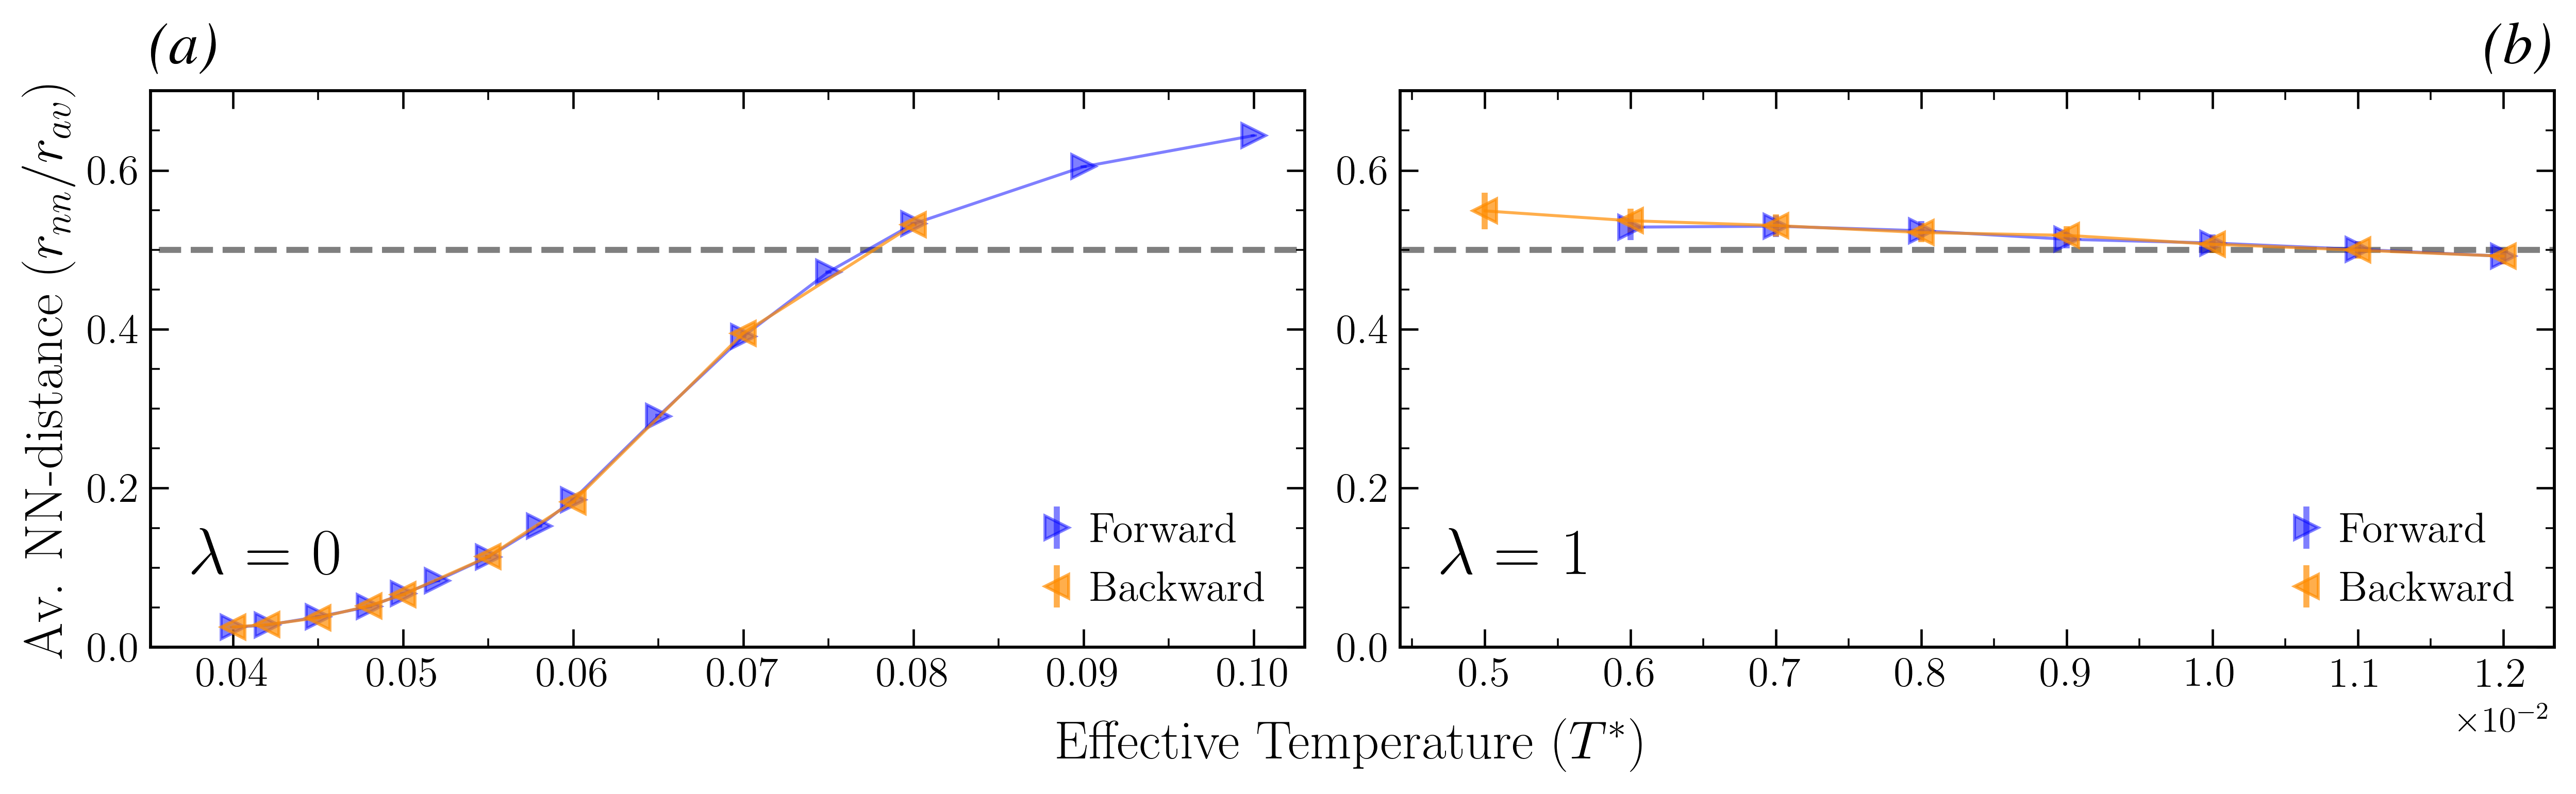

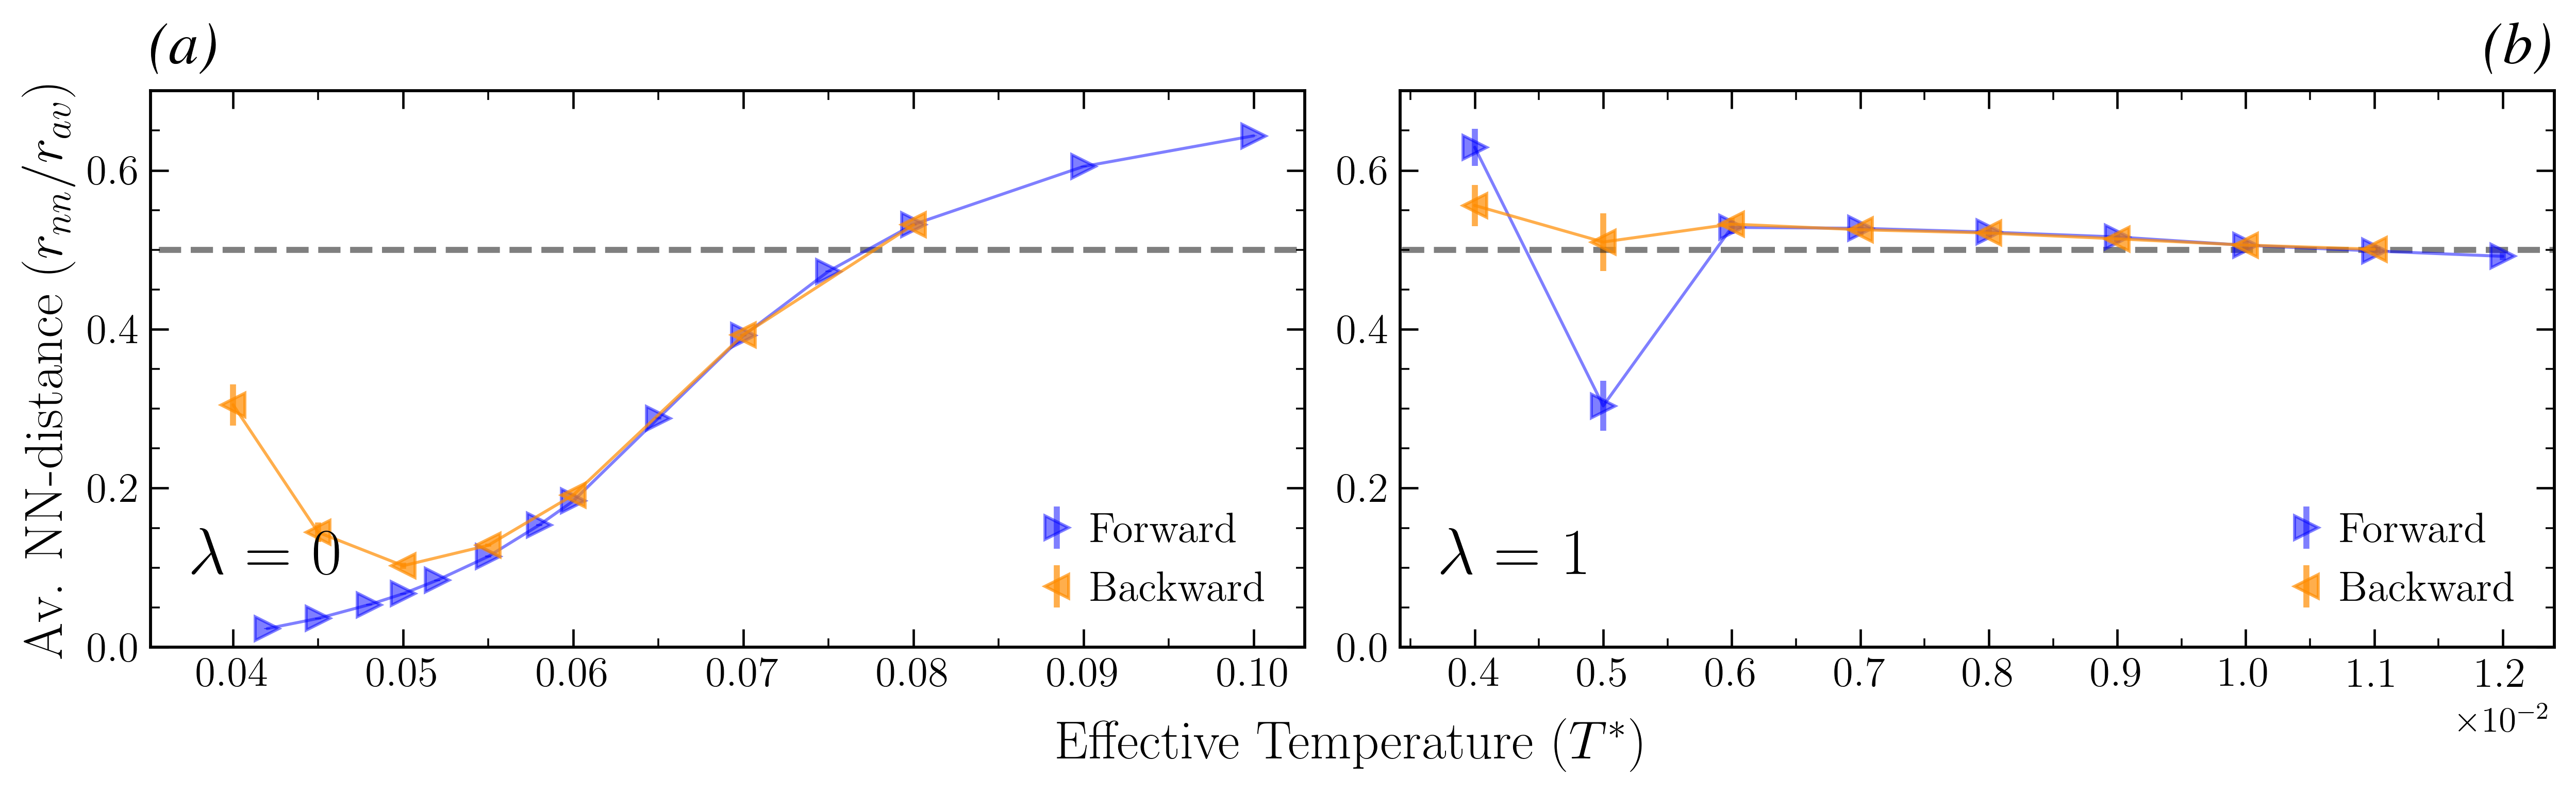

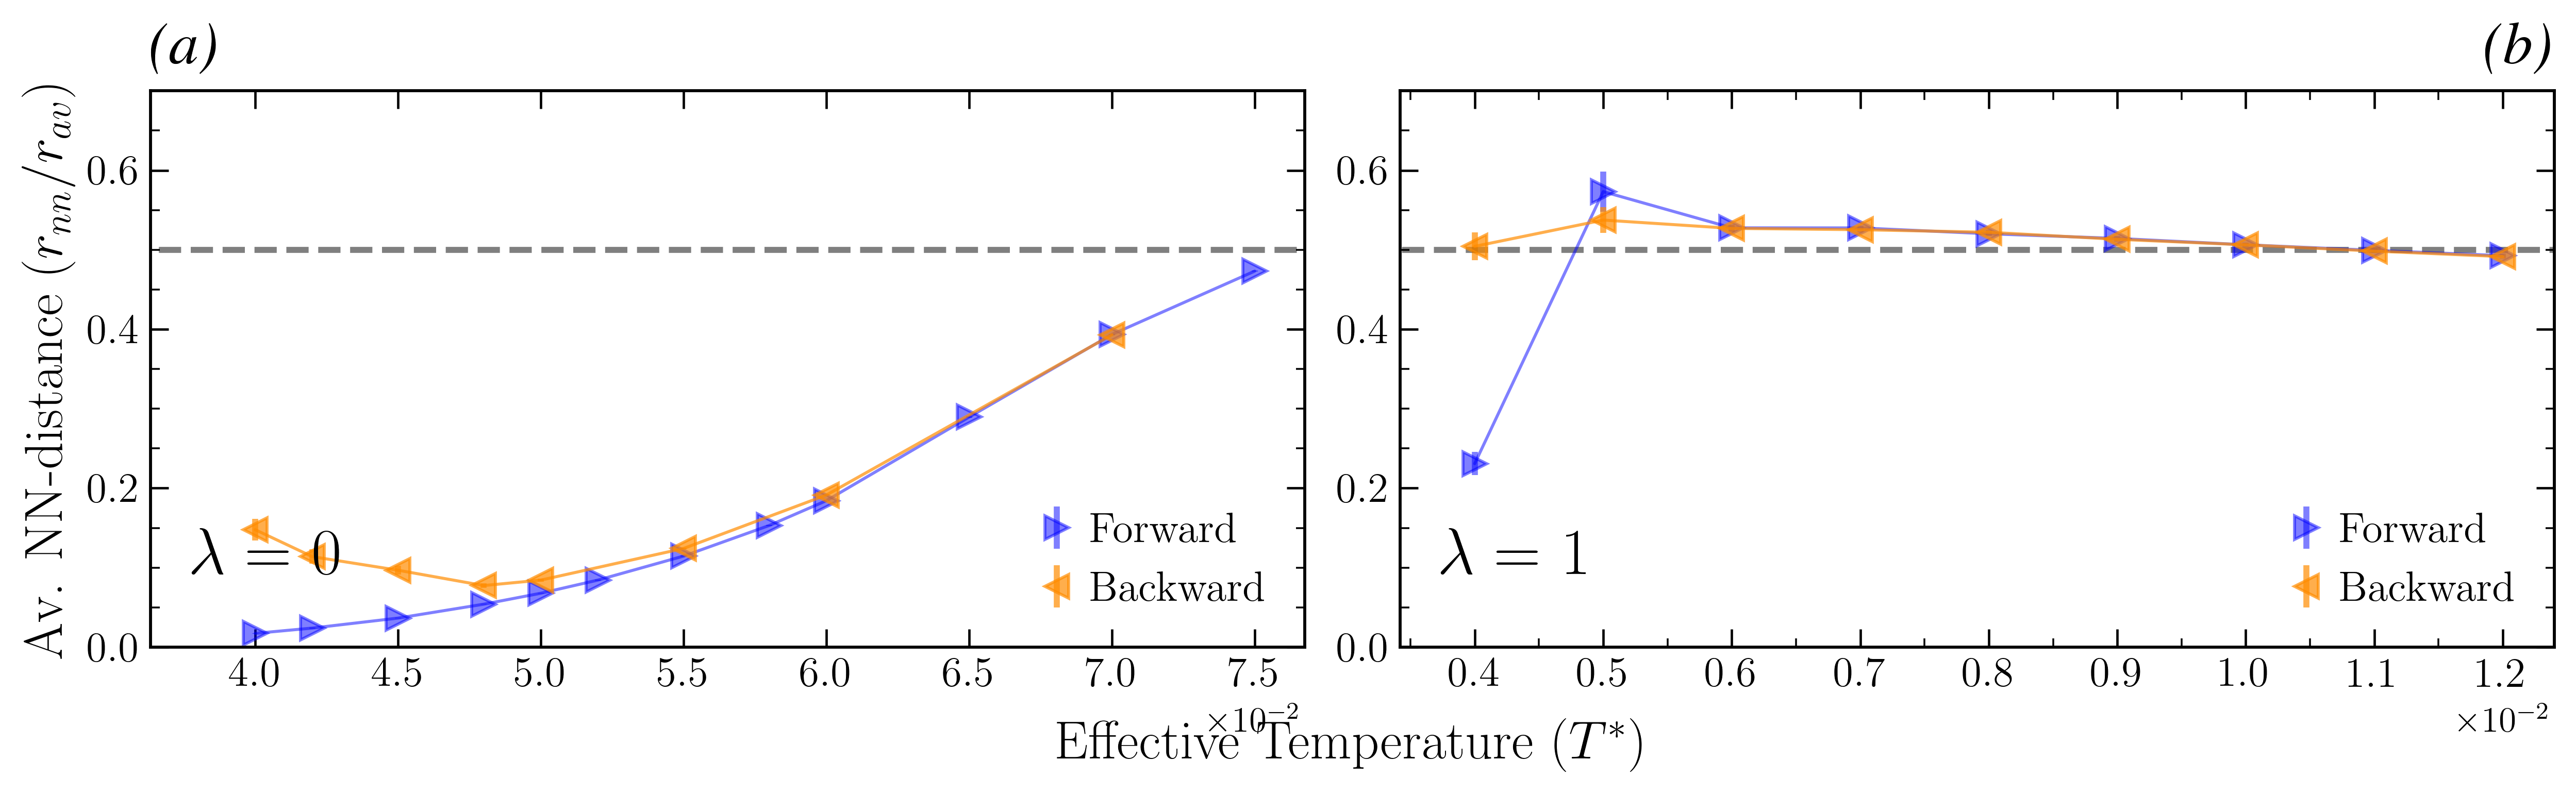

In [ ]:
### Passive RNN plot ###

plt.rcParams.update({"text.usetex": True, "legend.fontsize": 14, 
                     "legend.handlelength": 0,
                     })

for LX in [128,256,512]:

    fig, ax = plt.subplots(ncols=2,figsize=(12, 4.))
    ax = ax.flatten()
    normalize=True
    marker_list = ['dotted', 'dashed', 'dashdot']
    ninfo = 1000

    act_fwd_replace_list = [[], [0.004]]
    act_bck_replace_list = [[], [0.004]]
    act_fwd_min_list = [0.04,0.004]
    act_bck_min_list = [0.04,0.004]
    act_fwd_exl_list = [[], []] #[0.005]]
    act_bck_exl_list = [[], []]

    for i, lambda_val in enumerate(lambda_list):
    # mode = 'wet'
        normalizer = LX if normalize else 1
        out_path_all = f'C:\\Users\\Simon Andersen\\Projects\\Projects\\Thesis\\NematicAnalysis\\data\\passive\\{folder_name}\\{mode}\\na{LX}'
        out_path_all_wet = f'C:\\Users\\Simon Andersen\\Projects\\Projects\\Thesis\\NematicAnalysis\\data\\passive\\diff_lambda_periodic\\wet\\na{LX}'
        
        out_path_main = os.path.join(out_path_all, f'{lambda_val}')
        out_path_fwd = os.path.join(out_path_main, 'fwd')
        out_path_bck = os.path.join(out_path_main, 'bck')

        act_bck = np.load(os.path.join(out_path_bck, 'act_bck.npy'))
        act_fwd = np.load(os.path.join(out_path_fwd, 'act_fwd.npy'))
        def_arr_bck = np.load(os.path.join(out_path_bck, 'def_arr.npy'))
        def_arr_fwd = np.load(os.path.join(out_path_fwd, 'def_arr.npy'))
        nn_arr_av_fwd = np.load(os.path.join(out_path_fwd, 'nn_av.npy'))
        nn_arr_av_bck = np.load(os.path.join(out_path_bck, 'nn_av.npy'))

        out_path_main_wet = os.path.join(out_path_all_wet, f'{lambda_val}')
        out_path_fwd_wet = os.path.join(out_path_main_wet, 'fwd')
        out_path_bck_wet = os.path.join(out_path_main_wet, 'bck')
        act_bck_wet = np.load(os.path.join(out_path_bck_wet, 'act_bck.npy'))
        act_fwd_wet = np.load(os.path.join(out_path_fwd_wet, 'act_fwd.npy'))
        nn_arr_av_fwd_wet = np.load(os.path.join(out_path_fwd_wet, 'nn_av.npy'))
        nn_arr_av_bck_wet = np.load(os.path.join(out_path_bck_wet, 'nn_av.npy'))

        # apply replacements on nn_arr_av
        for act_replace in act_fwd_replace_list[i]:
            if act_replace in act_fwd:
                act_idx = np.argwhere(act_fwd == act_replace)[0][0]
                act_idx_wet = np.argwhere(act_fwd_wet == act_replace)[0][0]
                print(act_fwd[act_idx], act_fwd_wet[act_idx_wet])
                nn_arr_av_fwd[act_idx,:] = nn_arr_av_fwd_wet[act_idx_wet,:]
        for act_replace in act_bck_replace_list[i]:
            if act_replace in act_bck:
                act_idx = np.argwhere(act_bck == act_replace)[0][0]
                act_idx_wet = np.argwhere(act_bck_wet == act_replace)[0][0]
                print(act_bck[act_idx], act_bck_wet[act_idx_wet])
                nn_arr_av_bck[act_idx,:] = nn_arr_av_bck_wet[act_idx_wet,:]

        # make activity masks 
        act_fwd_mask = (act_fwd >=  act_fwd_min_list[i])
        act_bck_mask = (act_bck >=  act_bck_min_list[i])
        for act_excl in act_fwd_exl_list[i]:
            if act_excl in act_fwd:
                act_idx = np.argwhere(act_fwd == act_excl)[0][0]
                act_fwd_mask[act_idx] = False
        for act_excl in act_bck_exl_list[i]:
            if act_excl in act_bck:
                act_idx = np.argwhere(act_bck == act_excl)[0][0]
                act_bck_mask[act_idx] = False

        

        ax[i].errorbar(act_fwd[act_fwd_mask], nn_arr_av_fwd[act_fwd_mask,0], yerr=nn_arr_av_fwd[act_fwd_mask,1], alpha=.5,ms=8,fmt='b>-', label=r'Forward', lw=1, elinewidth=2)# if i==0 else None)#$\overline{l_{max}}$ (Forward)' if i==0 else None)# label=r'$\overline{l_{max}}$')
        ax[i].errorbar(act_bck[act_bck_mask], nn_arr_av_bck[act_bck_mask,0], yerr=nn_arr_av_bck[act_bck_mask,1], fmt='<-',color='darkorange', alpha=.7, ms=8,lw=1, elinewidth=2, label=r'Backward')#  if i==0 else None) # $~~~~~~~~~\hspace{5em}$' if i==0 else None)# label=r'$\overline{l_{perc}}$')

        ax[i].set_ylim([0, .7])#0.8))
    # ax[i].set_xlim([-2.5e-3 if i==0 else -2.5e-4, max(act_fwd[-1], act_bck[-1]) + 2.5e-3 if i==0 \
        #                else max(act_fwd[-1], act_bck[-1]) + 2.5e-4])
        ax[i].set_xlim(ax[i].get_xlim()[0]*0.95, ax[i].get_xlim()[1])

        ax[i].yaxis.set_minor_locator(ticker.MultipleLocator(0.05))
        ax[i].xaxis.set_minor_locator(ticker.MultipleLocator(0.005 if i==0 else 0.0005))
        ax[i].hlines(0.5, -.12,.12, linestyle='--', color='black', alpha=0.5,)

        ax[i].legend(fontsize=14, loc='lower right',) # handlelength=1, ncol=1) #if i==0 else None)
        ax[i].text(0.035, 0.13, rf'$\lambda = ~${lambda_val}', transform=ax[i].transAxes, fontsize=22)
        

    ax[0].set_ylabel(r'Av. NN-distance ($r_{nn}/r_{av}$)')
    fig.supxlabel(r'Effective Temperature ($T^*$)',x=.525,y=0.095)

    for n, AXX in enumerate(ax):
        n0 = 0
        AXX.tick_params(axis='both',which='major', labelsize=14 if n==0 else 14)
        AXX.text(0.0 if n==0 else 0.94, 1.05, rf"{{\fontfamily{{ntxtlf}}\selectfont\textit{{({string.ascii_lowercase[n]})}}}}", transform=AXX.transAxes,
                size=20,  weight='normal',fontstyle='italic',fontfamily="Times New Roman", color = 'black' if letter_subfigs else 'white',)

    fig.tight_layout()
    save_path = os.path.join(out_path_all, 'figs')
    if not os.path.isdir(save_path):
        os.makedirs(save_path)

    if save_figs:
    # fig.savefig(os.path.join(save_path, f'rnn_av_v4{"_unlabeled" if not letter_subfigs else ""}.png'), dpi=720, bbox_inches='tight', pad_inches=.035)
    # fig.savefig(os.path.join(figpath_article, f'rnn_av_v4{"_unlabeled" if not letter_subfigs else ""}.png'), dpi=720, bbox_inches='tight', pad_inches=.035) 
        print("Saved figure to ", os.path.join(save_path, f'rnn_av_v4{"_unlabeled" if not letter_subfigs else ""}.png'))